## load package

In [7]:
# load package
# string 
import re

# math
import pandas as pd
import numpy as np
import scipy as sp
import random

# sys
import sys
import os
import time
import warnings

# date
from datetime import datetime, timedelta

# math
import math

# preprocessing
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler, MinMaxScaler, QuantileTransformer, PowerTransformer

# machine learning
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, gaussian_process, discriminant_analysis
from xgboost import XGBClassifier

# model utils
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn import feature_selection 
from sklearn import model_selection
from sklearn import metrics

# plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix #??
# = show plots in Jupyter Notebook browser
%matplotlib inline 
mpl.style.use('ggplot') #??
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8 #??

# show all columns
from IPython.display import display
pd.options.display.max_columns = None

# memory manage
import gc

# logging
import logging 

# other
import tqdm as tqdm

# self define
sys.path.append('../../utils/')

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [293]:
# for network design
import torch
import argparse
import os

from scipy.stats import stats
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler

In [8]:
logging.basicConfig(level = logging.INFO, format = '%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler = logging.FileHandler('../log/extract_features.log')
handler.setLevel(logging.INFO)
formater = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formater)
logger = logging.getLogger(__name__)
logger.addHandler(handler)
logger.info('This is a log info')

2018-11-20 09:12:25,687 - __main__ - INFO - This is a log info


In [9]:
# read files
lb_wsp_2014 = pd.read_csv('../data/Autohaus_weeber/leonberg_werkstattposten_2014.csv', sep = ';')
lb_wsp_2015 = pd.read_csv('../data/Autohaus_weeber/leonberg_werkstattposten_2015.csv', sep = ';')
lb_wsp_2016 = pd.read_csv('../data/Autohaus_weeber/leonberg_werkstattposten_2016.csv', sep = ';')
lb_wsp_2017 = pd.read_csv('../data/Autohaus_weeber/leonberg_werkstattposten_2017.csv', sep = ';')
lb_wsp_2018 = pd.read_csv('../data/Autohaus_weeber/leonberg_werkstattposten_2018.csv', sep = ';')
std_wsp_2014 = pd.read_csv('../data/Autohaus_weeber/weil_der_stadt_werkstattposten_2014.csv', sep = ';')
std_wsp_2015 = pd.read_csv('../data/Autohaus_weeber/weil_der_stadt_werkstattposten_2015.csv', sep = ';')
std_wsp_2016 = pd.read_csv('../data/Autohaus_weeber/weil_der_stadt_werkstattposten_2016.csv', sep = ';')
std_wsp_2017 = pd.read_csv('../data/Autohaus_weeber/weil_der_stadt_werkstattposten_2017.csv', sep = ';')
std_wsp_2018 = pd.read_csv('../data/Autohaus_weeber/weil_der_stadt_werkstattposten_2018.csv', sep = ';')
# cat
d1 = lb_wsp_2014.copy()
d2 = lb_wsp_2015.copy()
d3 = lb_wsp_2016.copy()
d4 = lb_wsp_2017.copy()
d5 = lb_wsp_2018.copy()

d6 = std_wsp_2014.copy()
d7 = std_wsp_2015.copy()
d8 = std_wsp_2016.copy()
d9 = std_wsp_2017.copy()
d10 = std_wsp_2018.copy()

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
# for training we use data from 14 - 17 in lb_wsp
train1 = pd.concat([d1,d2,d3,d4,d5], 0)
train2 = pd.concat([d6,d7,d8,d9,d10], 0)
train1['Autohaus'] = 'leonberg'
train2['Autohaus'] = 'weil'
#train = pd.concat([train1, train2], 0)
#train = train1.copy()

In [11]:
# because there exists reused Auftragsnummer in different Autohaus station. So we add some sign to the Auftragsnummer
# in each Autohaus station
train1['Auftragsnummer'] = 'A' + train1['Auftragsnummer']
train2['Auftragsnummer'] = 'B' + train2['Auftragsnummer']
train = pd.concat([train1, train2], 0)

## extract Teile-Gruppe
An 4 . Stelle der Teile-Nr ist die Baugruppe 
- 1 - Motor
- 2 - Kraftstoff, Abgas, Kühlung
- 3 - Getrieb
- 4 - Vorderachse, Lenkung
- 5 - Hinterachse
- 6 - Räder
- 7 - Hebelwerk
- 8 - Karosserie
- 9 - Elektrik
- 0 - Zubehör, Infotainment, Sonstiges

#### remove the outlier in the Teile-Nr
- na wert
- Teile-Nr, which length smaller than 4
- doesn't contain number??
- doesn't contain adjoining number 

Question: The Gruppe-Nr can also in the 5. stelle<br>
#df[df['Teile-Nr'].map(lambda x: bool(re.search('[a-zA-Z]', x[3])))]['Teile-Nr']<br>
the command show the Teile-Nr, which type are not number. We can see that many Teile-Nr doesn't contrain number; some Teile-Nr contain number, however there are not in the 4. stelle bu in the 5. oder 6. stelle. Therefore we suggest that the first coming adjoining nummer in the Teile-Nr may be the gruppe-Nr.<br>
We extract the gruppe-Nr according to this idea.<br>
This phase takes train data as input and output Dataframe df

In [12]:
# remove the outlier in the Teile-Nr
# remove the na wert
df = train[train['Teile-Nr'].isna().map(lambda x: not x)]
# remove the value short value
df = df[df['Teile-Nr'].map(lambda x: False if len(x) < 4 else True)]
# remove the value that doesn't contain number: 30593 of 593527 in train1(5%)
df = df[df['Teile-Nr'].map(lambda x: True if re.search('\d', x) else False)]
# remove the value that doesn't contrain adjoining number(min 2 number): 594 of 562934 in train1(0.1%)
df = df[df['Teile-Nr'].map(lambda x: True if re.search('\d\d', x) else False)]

In [13]:
# use findall instead of search, because, the df here should contain adjoining number, otherwise it's wrong
df['Gruppe-Nr'] = df['Teile-Nr'].map(lambda x: re.findall('\d\d', x)[0][0])

In [14]:
df['Gruppe-Nr'].value_counts()

0    930093
1    281620
9    241658
3     46656
2     37419
6     23866
8     21086
5     19447
4     14385
7      6041
Name: Gruppe-Nr, dtype: int64

In [15]:
# clean the memory
del train1, train2, lb_wsp_2014, lb_wsp_2015, lb_wsp_2016, lb_wsp_2017, lb_wsp_2018
del std_wsp_2014, std_wsp_2015, std_wsp_2016, std_wsp_2017, std_wsp_2018
del d1, d2, d3, d4, d5, d6, d7, d8, d9, d10
gc.collect()

91

In [16]:
#

## remove the confused data
- For the same Auftragsnummer, exists more than one value in the other attribute.
- wierd Auftragsnummer: 107K, 77KW
- Fahrgestellnummer is Na
- Fahrgestellnummer that only contrain number.
- In Auftragsdatum, the day of the datum is larger than 31
- Wierd Auftragsdatum, these datum is shorter than 10 Ziffer.
- Wierd Auftragsdatum, these datum is smaller than 2013

In [17]:
# not only see that data with gruppe-nr == 9, 241658 items
# the target of next coming can also for the other thing, not the eletric
# df = df[df['Gruppe-Nr'] == '9']

In [18]:
# choose the features, which may be essentail to the model
# We will take care of the 'AW-Nr' and 'KM-Stand' in the other place.
# there are 98256 unique items in cf, more than 90423 items in af, which means they may create NA value after merging
#cf = train[['Auftragsnummer', 'AW-Nr', 'Markencode', 'Lagerortcode', 'Adressanredecode', 'Motorcode', 'Fahrzeugmodellnummer', 'Modell', 'Typ',
#        'Getriebecode', 'Gewicht', 'Leistung (KW)', 'Fahrgestellnummer']]
cf = df.copy()

In [19]:
# drop duplicate
cf = cf.drop_duplicates()

In [20]:
# find out the confused data. For the same Auftragsnummer, exists more than one value in the other attribute.
# here is AWSAU310019, BWSAU386471, BWSAU435051
cf = cf.drop(cf[cf['Auftragsnummer'] == 'AWSAU310019'].index, axis= 0) # 8 items
cf = cf.drop(cf[cf['Auftragsnummer'] == 'BWSAU386471'].index, axis= 0) # 3 items
cf = cf.drop(cf[cf['Auftragsnummer'] == 'BWSAU435051'].index, axis= 0) # 2 items
cf = cf.drop(cf[cf['Auftragsnummer'] == 'BWSAU271939'].index, axis= 0) # ? items

In [21]:
# remove wierd auftragsnummer
cf = cf.drop(cf[cf['Auftragsnummer'] == '103K'].index) #
cf = cf.drop(cf[cf['Auftragsnummer'] == '77KW'].index) #

In [22]:
# remove na value in Fahrgestellnummer
cf = cf.drop(cf[cf['Fahrgestellnummer'].isna()].index, axis = 0) #

In [23]:
# remove the Fahrgestellnumer that only contain number, not tested!!!!
cf = cf.drop(cf[cf['Fahrgestellnummer'].map(lambda x: False if re.search('[a-zA-Z]', x) else True)].index, axis = 0)

In [24]:
# remove the items, which day of the Auftragsdatum lareger than 31, not tested!!!!
cf = cf.drop(cf[cf['Auftragsdatum'].map(lambda x: int(x[0:2])) > 31].index, axis = 0)

In [25]:
# remove the items, which length of the Auftragsdatum shorter than 10, not tested!!!!
cf = cf.drop(cf[cf['Auftragsdatum'].map(lambda x:True if len(x) < 10 else False)].index, axis = 0)

In [26]:
# remove the items, which year of the Auftragsdatum smaller than 2013, not tested!!!!
cf = cf.drop(cf[cf['Auftragsdatum'].map(lambda x: int(x[6:]) < 2013)].index, axis = 0)

In [27]:
#len(cf)

In [28]:
df = cf
del cf
gc.collect()

195

In [29]:
#check_to_1(tmp, 'Auftragsnummer', 'Markencode')

In [30]:
#check_to_1(tmp, 'Auftragsnummer', 'Lagerortcode')

In [31]:
#check_to_1(tmp, 'Auftragsnummer', 'Adressanredecode')

In [32]:
#check_to_1(tmp, 'Auftragsnummer', 'Motorcode')

In [33]:
#check_to_1(tmp, 'Auftragsnummer', 'Fahrzeugmodellnummer')

In [34]:
#check_to_1(tmp, 'Auftragsnummer', 'Modell')

In [35]:
#check_to_1(tmp, 'Auftragsnummer', 'Typ')

In [36]:
#check_to_1(tmp, 'Auftragsnummer', 'Getriebecode')

In [37]:
#check_to_1(tmp, 'Auftragsnummer', 'Gewicht')

In [38]:
#check_to_1(tmp, 'Auftragsnummer', 'Leistung (KW)')

In [39]:
#check_to_1(tmp, 'Auftragsnummer', 'Fahrgestellnummer')

In [40]:
#check_to_1(train, 'Auftragsnummer', 'KM-Stand')

In [41]:
#check_to_1(train, 'Auftragsnummer', 'Erstzulassungsdatum')

## Get Auftrag table for Gruppe-Nr

In [42]:
gn = df.copy()

In [43]:
gn = toAuftragTable(gn, 'Gruppe-Nr', 'Auftragsnummer') # number: 245018

Falls Null date exist, drop these dates directly


In [44]:
len(gn)

244077

## extract feature: total AW-Nr
extract the feature total AW and combine aw with gruppe-nr auftragstable to form a new Dataframe agn. <br>
combine the attribute in df to the agn

In [45]:
aw = train.copy() # can't use df here, because df delete all the na value in Teile-Nr

In [46]:
# remove the items, that contain ziffer in the AW-Nr, set data type to int
aw['AW-Nr'][aw['AW-Nr'].isnull()] = 0 # set null value to 0
aw['AW-Nr'][aw['AW-Nr'] == '99999999'] = 0 # set 99999999 to 0
aw['AW-Nr'] = aw['AW-Nr'].map(lambda x: re.sub(' ', '', str(x)))# remove space between the number
del_index = aw[aw['AW-Nr'].map(lambda x: bool(re.search('[a-zA-Z]', str(x))))].index # remove fake data
aw = aw.drop(del_index) 
aw['AW-Nr'] = aw['AW-Nr'].astype('float')

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [47]:
# to auftrag table, get the feature: total AW-Nr for each auftrag
tmp = aw[['AW-Nr', 'Auftragsnummer']]
ag = tmp.groupby('Auftragsnummer', as_index = False)
out = []
for name, gruppe in ag:
    out.append(pd.DataFrame({'Auftragsnummer': [gruppe['Auftragsnummer'].iloc[0]], 'total AW': [gruppe['AW-Nr'].sum()]}))
aw = pd.concat(out).reset_index()[['Auftragsnummer', 'total AW']] # 缺分段
# drop the wierd Auftragsnummer
aw = aw.drop(aw[aw['Auftragsnummer'] == '103K'].index)
aw = aw.drop(aw[aw['Auftragsnummer'] == '77KW'].index)

In [48]:
# the lengths of aw and gn are different, because in some auftrag, the customer do not buy anything. 
# These part of auftrags are not included in gn, but gn is not a subset of aw. 
# because some AW-Nr in aw are wrong, we have deleted these items in aw. 
# Therefore, if we want to merge aw and gn, we have to use the method inner
agn = pd.merge(aw, gn, how = 'inner', on = 'Auftragsnummer')

## extract feature: num_act
not tested jet<br>
make sure that, the length of the output, shoube be the same as the length of agn

In [49]:
aw = train.copy()
# remove the items, that contain ziffer in the AW-Nr, set data type to int
aw['AW-Nr'][aw['AW-Nr'].isnull()] = 0 # set null value to 0
aw['AW-Nr'][aw['AW-Nr'] == '99999999'] = 0 # set 99999999 to 0
aw['AW-Nr'] = aw['AW-Nr'].map(lambda x: re.sub(' ', '', str(x)))# remove space between the number
del_index = aw[aw['AW-Nr'].map(lambda x: bool(re.search('[a-zA-Z]', str(x))))].index # remove fake data
aw = aw.drop(del_index) 
aw['AW-Nr'] = aw['AW-Nr'].astype('float')
# to auftrag table, get the feature: total AW-Nr for each auftrag
tmp = aw[['AW-Nr', 'Auftragsnummer']]
ag = tmp.groupby('Auftragsnummer', as_index = False)
out = []
for name, gruppe in ag:
    out.append(pd.DataFrame({'Auftragsnummer': [gruppe['Auftragsnummer'].iloc[0]], 'num_act': [len(gruppe)]}))
aw = pd.concat(out).reset_index()[['Auftragsnummer', 'num_act']] # 缺分段
# drop the wierd Auftragsnummer
aw = aw.drop(aw[aw['Auftragsnummer'] == '103K'].index)
aw = aw.drop(aw[aw['Auftragsnummer'] == '77KW'].index)

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [50]:
#agn = pd.merge(aw, agn, how = 'inner', on = 'Auftragsnummer')
agn = pd.merge(aw, agn, how = 'inner', on = 'Auftragsnummer')

In [51]:
agn.head()

,Auftragsnummer,num_act,total AW,Gruppe-Nr
0,AWSAU195981,31,1.526062e+09,0;3
1,AWSAU198256,31,6.398138e+08,0;1;9
2,AWSAU200129,14,3.832960e+08,0;6;1;9
3,AWSAU200223,60,1.841819e+09,6;5;3;0;9;1
4,AWSAU200258,23,5.367113e+08,0;1;9


In [52]:
#train[train['Auftragsnummer'] == 'AWSAU195981']

## extract feature: num_teile

In [53]:
agn['num_teile'] = agn['Gruppe-Nr'].map(lambda x: len(x.split(';')))

In [54]:
agn[['total AW', 'num_act']].corr() 
# why the correlation is so small??

,total AW,num_act
total AW,1.000000,0.584288
num_act,0.584288,1.000000


In [55]:
del aw, gn
gc.collect()

112

## combine agn with df

In [56]:
tmp = df[['Auftragsnummer', 'KM-Stand','Markencode', 'Lagerortcode', 'Auftragsdatum', 'Adressanredecode', 'Motorcode', 'Fahrzeugmodellnummer', 'Modell', 'Typ', 
          'Getriebecode', 'Gewicht', 'Leistung (KW)', 'Fahrgestellnummer', 'Erstzulassungsdatum']]
tmp = tmp.drop_duplicates()
tmp = pd.merge(agn, tmp, how = 'inner', on = 'Auftragsnummer') # 244608

In [57]:
df = tmp
del tmp
gc.collect()

41

In [58]:
#TODO
# calculate the length of aw and original df
# i suggest that, because i delete all the na value in Teile-Nr, the number of items in original df is smaller
# than the number in aw.
# the result is, after mergin, there are many na value in some attribute, 
# i want to see the number of distance.
# or may be i can merge the data in the other direction: 'right'
# but mit direction right, there exist also 600 null value but in total AN, the reason may be
# that i delete some fake data in aw.
# the problem here is, should i maintain the na value in total AW, other just remove all of them?

## extract features: month, day

In [59]:
md = df.copy()
# remove the outlier in the data
#fake = md[md['Auftragsdatum'].map(lambda x:True if re.search('[a-zA-Z]', x) else False)]
#md = md.drop(fake.index, axis=0)

In [60]:
md['year'] = md['Auftragsdatum'].map(lambda x: x[6:])
md['month'] = md['Auftragsdatum'].map(lambda x: x[3:5])
md['day'] = md['Auftragsdatum'].map(lambda x: x[0:2])

In [61]:
df = md
del md
gc.collect()

28

In [62]:
df['num_teile'].value_counts()

1     99287
3     66428
2     50047
4     20344
5      5373
6      1446
7       494
8       185
9        53
10       10
Name: num_teile, dtype: int64

## extract feature: age
not tested jet!!!<br>
age_auto = auftragsdatum - Erstzulassungsdatum<br>
age_autohaus = auftragsdatum - 2013

In [63]:
#tmp = train[['Auftragsdatum', 'Erstzulassungsdatum']]
tmp = df.copy()

In [64]:
tmp['Auftragsdatum'] = pd.to_datetime(tmp['Auftragsdatum'], dayfirst=True)
tmp['Erstzulassungsdatum'] = pd.to_datetime(tmp['Erstzulassungsdatum'], dayfirst=True)
tmp['age_auto'] = tmp['Auftragsdatum'] - tmp['Erstzulassungsdatum']
tmp['age_auto'] = tmp['age_auto'].map(lambda x: x.days) % 365 # not test jet

In [65]:
tmp['age_autohaus'] = tmp['Auftragsdatum'].map(lambda x: x.year) - 2013

In [66]:
df = tmp
del tmp
gc.collect()

14

In [67]:
df.head(10)

,Auftragsnummer,num_act,total AW,Gruppe-Nr,num_teile,KM-Stand,Markencode,Lagerortcode,Auftragsdatum,Adressanredecode,Motorcode,Fahrzeugmodellnummer,Modell,Typ,Getriebecode,Gewicht,Leistung (KW),Fahrgestellnummer,Erstzulassungsdatum,year,month,day,age_auto,age_autohaus
0,AWSAU195981,31,1.526062e+09,0;3,2,"38110,00",VW,"Weeber Leonberg VW (Glemseckstraße 49, 71229 L...",2014-01-13,Firma,CRBC,5G131X,Golf VII 2.0 TDI CL BMT,X0A,PFL,"0,00",110.0,WVWZZZAUZDP084627,2013-05-17,2014,01,13,241.0,1
1,AWSAU198256,31,6.398138e+08,0;1;9,3,"59660,00",AUDI,"Weeber Leonberg Audi (Glemseckstraße 39, 71229...",2014-01-16,AN,CJC,8K50SC,Audi A4 Attraction Avant 2.0 T,X0A,MVS,"0,00",0.0,WAUZZZ8K0DA098516,2012-07-27,2014,01,16,173.0,1
2,AWSAU200129,14,3.832960e+08,0;6;1;9,4,"227777,00",VW,"Weeber Leonberg VW (Glemseckstraße 49, 71229 L...",2014-01-09,Herr,CBAB,5K143M,"Golf Highline 2,0 l",X0A,LQV,"0,00",0.0,WVWZZZ1KZAW187314,2009-11-25,2014,01,09,46.0,1
3,AWSAU200223,60,1.841819e+09,6;5;3;0;9;1,6,"65174,00",VW,"Weeber Leonberg VW (Glemseckstraße 49, 71229 L...",2014-01-07,Herr,AXR,1J5134,VW Golf IV > 98 / Variant > 99,NaN,EUH,"0,00",0.0,WVWZZZ1JZ2W511716,2002-02-15,2014,01,07,329.0,1
4,AWSAU200258,23,5.367113e+08,0;1;9,3,"212110,00",AUDI,"Weeber Leonberg Audi (Glemseckstraße 39, 71229...",2014-01-02,Firma,CAGA,8K50QC,A4 Avant 2.0 TDI Attraction,X0A,LLN,"0,00",105.0,WAUZZZ8K5AA164327,2010-05-06,2014,01,02,242.0,1
5,AWSAU200259,9,1.862719e+08,0;9,2,"91895,00",AUDI,"Weeber Leonberg Audi (Glemseckstraße 39, 71229...",2014-01-02,Herr,ALT,8E20B4,A4 Limousine 2.0 R4 96 M5S,NaN,GBM,"0,00",0.0,WAUZZZ8E13A363100,2003-04-24,2014,01,02,256.0,1
6,AWSAU200260,11,3.962096e+08,0,1,"122325,00",AUDI,"Weeber Leonberg Audi (Glemseckstraße 39, 71229...",2014-01-02,Herr,CAYC,8P1AE4,Audi A3 Attraction 3-Türer 1.6,X0A,LUB,"0,00",0.0,WAUZZZ8PXAA157479,2010-04-29,2014,01,02,249.0,1
7,AWSAU200263,36,6.978901e+08,0;1;9;3,4,"112386,00",AUDI,"Weeber Leonberg Audi (Glemseckstraße 39, 71229...",2014-01-02,Herr,ASB,4F20LL,Audi A6 Limousine 3.0 TDI (DPF,X0A,KGX,"0,00",0.0,WAUZZZ4F28N185258,2008-10-04,2014,01,02,91.0,1
8,AWSAU200264,12,1.656055e+08,0;8;3,3,"42783,00",AUDI,"Weeber Leonberg Audi (Glemseckstraße 39, 71229...",2014-01-02,Herr,CLAB,4G50NH,A6 Avant 3.0 TDI,X0A,NKP,"0,00",150.0,WAUZZZ4G4CN101295,2012-02-21,2014,01,02,316.0,1
9,AWSAU200269,8,1.641055e+08,0;3,2,"180999,00",AUDI,"Weeber Leonberg Audi (Glemseckstraße 39, 71229...",2014-01-02,Herr,BPP,8ED0YH,Audi A4 Avant 2.7 TDI(DPF),X0A,JBB,"0,00",0.0,WAUZZZ8E07A224307,2007-03-29,2014,01,02,281.0,1


## transfer the type of km stand to float

In [68]:
df['KM-Stand'] = df['KM-Stand'].map(lambda x: float(re.sub(',', '.', x)))

## extract feature: KM age

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243667 entries, 0 to 243666
Data columns (total 24 columns):
Auftragsnummer          243667 non-null object
num_act                 243667 non-null int64
total AW                243667 non-null float64
Gruppe-Nr               243667 non-null object
num_teile               243667 non-null int64
KM-Stand                243667 non-null float64
Markencode              243468 non-null object
Lagerortcode            243667 non-null object
Auftragsdatum           243667 non-null datetime64[ns]
Adressanredecode        241586 non-null object
Motorcode               235550 non-null object
Fahrzeugmodellnummer    243477 non-null object
Modell                  242305 non-null object
Typ                     162462 non-null object
Getriebecode            234752 non-null object
Gewicht                 243461 non-null object
Leistung (KW)           243461 non-null float64
Fahrgestellnummer       243667 non-null object
Erstzulassungsdatum     243461 non

## extract feature: time relative
- times in group
- time distance since last come
- time distance to next come
- km stand distance since last come(correct the data first)
- km stand distance to next come
- is km stand to/from next/last come larger than threshold
- frequent in each year, in total
- (not jet)weather come in X month again
- time shift for num_act, total aw, Gruppe-Nr, num_teile
- repair age in year or in month
- repair frequent in last X month
- trend of frequent in the past
- mean, max, min, quater repaire km distance
- mean, max, min, quater repaire time distance

We sort the dataframe with ['Fahrgestellnummer', 'Auftragsdatum'], and calculate the datum distance betwenn the nearby items.<br>
One thing to be clear is that, the first distance for each Fahrgestellnummer is wrong, because we calculate it with the its Auftragsdatum and the Auftragsdatum of the other Fahrgestellnummer.<br>

In [ ]:
td = df.copy()

In [ ]:
td = td[['Fahrgestellnummer', 'Auftragsdatum', 'KM-Stand','num_act', 'total AW', 'num_teile', 'year']]
#1C8FYN8O63T585854 8

In [ ]:
# get sample, to test the code
for name, group in td.groupby('Fahrgestellnummer', as_index = False):
    if name == '1C8FYN8O63T585854':
        tmp = group.reindex()
        print(tmp.columns)
        print(tmp.index)
        # time distance since/to last/next come
     #create feature: time distance from last coming

In [ ]:
# code to extract new features, remmenber to remove counter
out = []
counter = 0
logger.info('create features: time relative:')
total_group = len(td['Fahrgestellnummer'].unique())
for name, group in td.groupby('Fahrgestellnummer', as_index = False):
    counter = counter + 1
    if counter > 1000:
        num_group = counter + 1
        logger.info('number of group: {} [{}/{} ({:0f}%)]'.format(num_group, num_group, total_group, 100*0.1*num_group/total_group))
        tmp_df = pd.concat(out)
        tmp_df.to_pickle('tmp.pkl')
        break
    #if name == '1C8FYN8O63T585854':
    #    tmp = group.reindex()
    #    print(tmp.columns)
    #    print(tmp.index)
    #    # time distance since/to last/next come
    # create feature: time distance from last coming
    tmp = group
    if len(tmp) > 1:
        tmp['times'] = len(tmp)
        tmp = tmp.sort_values(by = 'Auftragsdatum').reset_index().iloc[:,1:] # not tested
        # create feature: time distance from last coming
        time_shift_forward = pd.concat([pd.Series(datetime(2010, 1, 1)), tmp['Auftragsdatum'][:-1]])
        time_shift_forward.index = tmp.index
        tmp['time_distance_from_last'] = tmp['Auftragsdatum'] - time_shift_forward
        tmp['time_distance_from_last'] = tmp['time_distance_from_last'].clip(lower = timedelta(0), upper = timedelta(365)) # clip
        # create feature: mean time distance in group, should i clip the data first????
        tmp['mean_time_distance_in_group'] = tmp['time_distance_from_last'].mean()
        # create feature: max time distance in group
        tmp['max_time_distance_in_group'] = tmp['time_distance_from_last'].max()
        # create feature: min time distance in group
        tmp['min_time_distance_in_group'] = tmp['time_distance_from_last'].min()
        # create feature: time distance to next coming
        time_distance_to_next = pd.concat([tmp['time_distance_from_last'][1:], pd.Series(np.NaN)])
        time_distance_to_next.index = tmp.index
        tmp['time_distance_to_next'] = time_distance_to_next
        # reset the first value and last value
        tmp.iloc[0, tmp.columns.get_loc('time_distance_from_last')] = np.NaN
        tmp.iloc[-1, tmp.columns.get_loc('time_distance_to_next')] = np.NaN
        # create feature: km stand distance from last coming
        km_shift_forward = pd.concat([pd.Series(0.0), tmp['KM-Stand'][:-1]])
        km_shift_forward.index = tmp.index
        tmp['km_distance_from_last'] = tmp['KM-Stand'] -km_shift_forward
        tmp['km_distance_from_last'] = tmp['km_distance_from_last'].abs() # correct the negative value in a stupid way!!!
        tmp['km_distance_from_last'][tmp['km_distance_from_last'] > 10000] = 10000 # clip
        # create feature: mean km stand distance, not test
        tmp['mean_km_distance_in_group'] = tmp['km_distance_from_last'].mean() 
        # create feature: max km stand distance, not test
        tmp['max_km_distance_in_group'] = tmp['km_distance_from_last'].max()
        # create feature: min km stand distance, not test
        tmp['min_km_distance_in_group'] = tmp['km_distance_from_last'].min()
        # create feature: km stand distance to next coming
        km_distance_to_next = pd.concat([tmp['km_distance_from_last'][1:], pd.Series(0.0)])
        km_distance_to_next.index = tmp.index
        tmp['km_distance_to_next'] = km_distance_to_next
        # reset the first value and last value
        tmp.iloc[0, tmp.columns.get_loc('km_distance_from_last')] = np.NaN
        tmp.iloc[-1, tmp.columns.get_loc('km_distance_to_next')] = np.NaN
        # create feature: frequent in each year
        year_candidates = ['2014', '2015', '2016', '2017', '2018']
        for year in year_candidates:
            tmp['frequent_in_'+year] = len(tmp[tmp['year'] == year])
        # create feature: time shift for num_act
        num_act_shift_forward  = pd.concat([pd.Series(np.NaN), tmp['num_act'][:-1]])
        num_act_shift_forward.index = tmp.index
        tmp['num_act_shift1'] = num_act_shift_forward
        # create feature: time shift for num_teile
        num_teile_shift_forward  = pd.concat([pd.Series(np.NaN), tmp['num_teile'][:-1]])
        num_teile_shift_forward.index = tmp.index
        tmp['num_teile_shift1'] = num_teile_shift_forward
        # create feature: time shift for total aw
        total_aw_shift_forward  = pd.concat([pd.Series(np.NaN), tmp['total AW'][:-1]])
        total_aw_shift_forward.index = tmp.index
        tmp['total_aw_shift1'] = total_aw_shift_forward
        if len(tmp) > 2:
            num_act_shift_forward2 = pd.concat([pd.Series([np.NaN, np.NaN]), tmp['num_act'][:-2]])
            num_act_shift_forward2.index = tmp.index
            tmp['num_act_shift2'] = num_act_shift_forward2
            num_teile_shift_forward2 = pd.concat([pd.Series([np.NaN, np.NaN]), tmp['num_teile'][:-2]])
            num_teile_shift_forward2.index = tmp.index
            tmp['num_teile_shift2'] = num_teile_shift_forward2
            total_aw_shift_forward2 = pd.concat([pd.Series([np.NaN, np.NaN]), tmp['total AW'][:-2]])
            total_aw_shift_forward2.index = tmp.index
            tmp['total_aw_shift2'] = total_aw_shift_forward2
        else:
            tmp['num_act_shift2'] = np.NaN
            tmp['num_teile_shift2'] = np.NaN
            tmp['total_aw_shift2'] = np.NaN
        # create feature: repair age in year or in month
        tmp['first_date'] = tmp.iloc[0, tmp.columns.get_loc('Auftragsdatum')]
        tmp['repair_age'] = tmp['Auftragsdatum'] - tmp['first_date']
        tmp = tmp.drop('first_date', axis=1)
        # create feature: repair frequent in last X month
        time_distance_shift1 = pd.concat([pd.Series(np.NaN), tmp['time_distance_from_last'][:-1]])
        time_distance_shift1.index = tmp.index
        tmp['time_distance_shift1'] = time_distance_shift1
        time_distance_shift2 = pd.concat([pd.Series(np.NaN), tmp['time_distance_shift1'][:-1]])
        time_distance_shift2.index = tmp.index
        tmp['time_distance_shift2'] = time_distance_shift2
        time_distance_shift3 = pd.concat([pd.Series(np.NaN), tmp['time_distance_shift2'][:-1]])
        time_distance_shift3.index = tmp.index
        tmp['time_distance_shift3'] = time_distance_shift3
        tmp['time_distance_from_last2'] = tmp['time_distance_from_last'] + tmp['time_distance_shift1']
        tmp['time_distance_from_last3'] = tmp['time_distance_from_last2'] + tmp['time_distance_shift2']
        tmp['time_distance_from_last4'] = tmp['time_distance_from_last3'] + tmp['time_distance_shift3']
        def get_frequent(x, d = 30):
            if x['time_distance_from_last4'] < timedelta(days = d):
                return 4
            elif x['time_distance_from_last3'] < timedelta(days = d):
                return 3
            elif x['time_distance_from_last2'] < timedelta(days = d):
                return 2
            elif x['time_distance_from_last'] < timedelta(days = d):
                return 1
            else:
                return 0
        tmp['frequent_in_last_1_month'] = tmp.apply(get_frequent, axis=1, args = [1*30])
        tmp['frequent_in_last_2_month'] = tmp.apply(get_frequent, axis=1, args = [2*30])
        tmp['frequent_in_last_3_month'] = tmp.apply(get_frequent, axis=1, args = [3*30])
        tmp['frequent_in_last_4_month'] = tmp.apply(get_frequent, axis=1, args = [4*30])
        tmp['frequent_in_last_5_month'] = tmp.apply(get_frequent, axis=1, args = [5*30])
        tmp['frequent_in_last_6_month'] = tmp.apply(get_frequent, axis=1, args = [6*30])
        # create feature: weather come in last X month
        tmp['weather_come_in_last_1_month'] = tmp['time_distance_from_last'] < timedelta(days = 1*30)
        tmp['weather_come_in_last_2_month'] = tmp['time_distance_from_last'] < timedelta(days = 2*30)
        tmp['weather_come_in_last_3_month'] = tmp['time_distance_from_last'] < timedelta(days = 3*30)
        tmp['weather_come_in_last_4_month'] = tmp['time_distance_from_last'] < timedelta(days = 4*30)
        tmp['weather_come_in_last_5_month'] = tmp['time_distance_from_last'] < timedelta(days = 5*30)
        tmp['weather_come_in_last_6_month'] = tmp['time_distance_from_last'] < timedelta(days = 6*30)
        # create feature: trend of frequent in the past
        def get_trend(x):
            xs = x[['time_distance_from_last', 'time_distance_shift1', 'time_distance_shift2', 'time_distance_shift3']].tolist()
            xs = [x.days for x in xs if not pd.isnull(x)]
            if len(xs) < 2:
                return 0
            ys = range(1, len(xs) + 1)
            xm = sum(xs)/len(xs)
            ym = sum(ys)/len(ys)
            xy = [x*y for x, y in zip(xs, ys)]
            xx = [x*y for x, y in zip(xs, xs)]
            up = sum(xy) - len(xs)*xm*ym
            down = sum(xx) - len(xs)*xm*xm
            if down == 0:
                return 0
            return up*1.0/down
        tmp['trend_of_frequent_in_the_past'] = tmp.apply(get_trend, axis=1)
        # mean km distance:
    else:
        # set features to NaN
        tmp['times'] = 1
        tmp['time_distance_from_last'] = pd.NaT
        tmp['time_distance_to_next'] = pd.NaT
        tmp['mean_time_distance_in_group'] = pd.NaT
        tmp['max_time_distance_in_group'] = pd.NaT
        tmp['min_time_distance_in_group'] = pd.NaT
        tmp['km_distance_from_last'] = np.NaN
        tmp['km_distance_to_next'] = np.NaN
        tmp['mean_km_distance_in_group'] = np.NaN
        tmp['max_km_distance_in_group'] = np.NaN
        tmp['min_km_distance_in_group'] = np.NaN
        tmp['frequent_in_2014'] = 1 if tmp.iloc[0, tmp.columns.get_loc('year')] == '2014' else 0
        tmp['frequent_in_2015'] = 1 if tmp.iloc[0, tmp.columns.get_loc('year')] == '2015' else 0
        tmp['frequent_in_2016'] = 1 if tmp.iloc[0, tmp.columns.get_loc('year')] == '2016' else 0
        tmp['frequent_in_2017'] = 1 if tmp.iloc[0, tmp.columns.get_loc('year')] == '2017' else 0
        tmp['frequent_in_2018'] = 1 if tmp.iloc[0, tmp.columns.get_loc('year')] == '2018' else 0
        tmp['num_act_shift1'] = np.NaN
        tmp['num_teile_shift1'] = np.NaN
        tmp['total_aw_shift1'] = np.NaN
        tmp['num_act_shift2'] = np.NaN
        tmp['num_teile_shift2'] = np.NaN
        tmp['total_aw_shift2'] = np.NaN
        tmp['time_distance_shift1'] = pd.NaT
        tmp['time_distance_shift2'] = pd.NaT
        tmp['time_distance_shift3'] = pd.NaT
        tmp['time_distance_from_last2'] = pd.NaT
        tmp['time_distance_from_last3'] = pd.NaT
        tmp['time_distance_from_last4'] = pd.NaT
        tmp['weather_come_in_last_1_month'] = False
        tmp['weather_come_in_last_2_month'] = False
        tmp['weather_come_in_last_3_month'] = False
        tmp['weather_come_in_last_4_month'] = False
        tmp['weather_come_in_last_5_month'] = False
        tmp['weather_come_in_last_6_month'] = False
        tmp['trend_of_frequent_in_the_past'] = 0
    out.append(tmp)

# i don't known why the warning appear??? try to figure it out, it can save lots of time.

In [73]:
df3 = pd.concat(out).reset_index().iloc[:, 1:]

In [74]:
#df3 = pd.read_pickle('../code/tmp.pkl')
df3 = pd.read_pickle("../code/ec1.pkl")

In [75]:
df3 = df3.reset_index().iloc[:, 1:]

In [72]:
# test code
# create feature: time distance from last coming
time_shift_forward = pd.concat([pd.Series(datetime(2010, 1, 1)), tmp['Auftragsdatum'][:-1]])
time_shift_forward.index = tmp.index
tmp['time_distance_from_last'] = tmp['Auftragsdatum'] - time_shift_forward
# create feature: time distance to next coming
time_distance_to_next = pd.concat([tmp['time_distance_from_last'][1:], pd.Series(np.NaN)])
time_distance_to_next.index = tmp.index
tmp['time_distance_to_next'] = time_distance_to_next
# reset the first value and last value
tmp.iloc[0, tmp.columns.get_loc('time_distance_from_last')] = np.NaN
tmp.iloc[-1, tmp.columns.get_loc('time_distance_to_next')] = np.NaN
# create feature: km stand distance from last coming
km_shift_forward = pd.concat([pd.Series(0.0), tmp['KM-Stand'][:-1]])
km_shift_forward.index = tmp.index
tmp['km_distance_from_last'] = tmp['KM-Stand'] -km_shift_forward
# create feature: km stand distance to next coming
km_distance_to_next = pd.concat([tmp['km_distance_from_last'][1:], pd.Series(0.0)])
km_distance_to_next.index = tmp.index
tmp['km_distance_to_next'] = km_distance_to_next
# reset the first value and last value
tmp.iloc[0, tmp.columns.get_loc('km_distance_from_last')] = np.NaN
tmp.iloc[-1, tmp.columns.get_loc('km_distance_to_next')] = np.NaN
# create feature: frequent in each year
year_candidates = ['2014', '2015', '2016', '2017', '2018']
for year in year_candidates:
    tmp['frequent_in_'+year] = len(tmp[tmp['year'] == year])
# create feature: time shift for num_act
num_act_shift_forward  = pd.concat([pd.Series(np.NaN), tmp['num_act'][:-1]])
num_act_shift_forward.index = tmp.index
tmp['num_act_shift1'] = num_act_shift_forward
# create feature: time shift for num_teile
num_teile_shift_forward  = pd.concat([pd.Series(np.NaN), tmp['num_teile'][:-1]])
num_teile_shift_forward.index = tmp.index
tmp['num_teile_shift1'] = num_teile_shift_forward
# create feature: time shift for total aw
total_aw_shift_forward  = pd.concat([pd.Series(np.NaN), tmp['total AW'][:-1]])
total_aw_shift_forward.index = tmp.index
tmp['total_aw_shift1'] = total_aw_shift_forward
if len(tmp) > 2:
    num_act_shift_forward2 = pd.concat([pd.Series([np.NaN, np.NaN]), tmp['num_act'][:-2]])
    num_act_shift_forward2.index = tmp.index
    tmp['num_act_shift2'] = num_act_shift_forward2
    num_teile_shift_forward2 = pd.concat([pd.Series([np.NaN, np.NaN]), tmp['num_teile'][:-2]])
    num_teile_shift_forward2.index = tmp.index
    tmp['num_teile_shift2'] = num_teile_shift_forward2
    total_aw_shift_forward2 = pd.concat([pd.Series([np.NaN, np.NaN]), tmp['total AW'][:-2]])
    total_aw_shift_forward2.index = tmp.index
    tmp['total_aw_shift2'] = total_aw_shift_forward2
else:
    tmp['num_act_shift2'] = np.NaN
    tmp['num_teile_shift2'] = np.NaN
    tmp['total_aw_shift2'] = np.NaN
# create feature: repair age in year or in month
tmp['first_date'] = tmp.iloc[0, tmp.columns.get_loc('Auftragsdatum')]
tmp['repair_age'] = tmp['Auftragsdatum'] - tmp['first_date']
tmp = tmp.drop('first_date', axis=1)
# create feature: repair frequent in last X month
time_distance_shift1 = pd.concat([pd.Series(np.NaN), tmp['time_distance_from_last'][:-1]])
time_distance_shift1.index = tmp.index
tmp['time_distance_shift1'] = time_distance_shift1
time_distance_shift2 = pd.concat([pd.Series(np.NaN), tmp['time_distance_shift1'][:-1]])
time_distance_shift2.index = tmp.index
tmp['time_distance_shift2'] = time_distance_shift2
time_distance_shift3 = pd.concat([pd.Series(np.NaN), tmp['time_distance_shift2'][:-1]])
time_distance_shift3.index = tmp.index
tmp['time_distance_shift3'] = time_distance_shift3
tmp['time_distance_from_last2'] = tmp['time_distance_from_last'] + tmp['time_distance_shift1']
tmp['time_distance_from_last3'] = tmp['time_distance_from_last2'] + tmp['time_distance_shift2']
tmp['time_distance_from_last4'] = tmp['time_distance_from_last3'] + tmp['time_distance_shift3']
def get_frequent(x, d = 30):
    if x['time_distance_from_last4'] < timedelta(days = d):
        return 4
    elif x['time_distance_from_last3'] < timedelta(days = d):
        return 3
    elif x['time_distance_from_last2'] < timedelta(days = d):
        return 2
    elif x['time_distance_from_last'] < timedelta(days = d):
        return 1
    else:
        return 0
tmp['frequent_in_last_1_month'] = tmp.apply(get_frequent, axis=1, args = [1*30])
tmp['frequent_in_last_2_month'] = tmp.apply(get_frequent, axis=1, args = [2*30])
tmp['frequent_in_last_3_month'] = tmp.apply(get_frequent, axis=1, args = [3*30])
tmp['frequent_in_last_4_month'] = tmp.apply(get_frequent, axis=1, args = [4*30])
tmp['frequent_in_last_5_month'] = tmp.apply(get_frequent, axis=1, args = [5*30])
tmp['frequent_in_last_6_month'] = tmp.apply(get_frequent, axis=1, args = [6*30])
# create feature: weather come in last X month
tmp['weather_come_in_last_1_month'] = tmp['time_distance_from_last'] < timedelta(days = 1*30)
tmp['weather_come_in_last_2_month'] = tmp['time_distance_from_last'] < timedelta(days = 2*30)
tmp['weather_come_in_last_3_month'] = tmp['time_distance_from_last'] < timedelta(days = 3*30)
tmp['weather_come_in_last_4_month'] = tmp['time_distance_from_last'] < timedelta(days = 4*30)
tmp['weather_come_in_last_5_month'] = tmp['time_distance_from_last'] < timedelta(days = 5*30)
tmp['weather_come_in_last_6_month'] = tmp['time_distance_from_last'] < timedelta(days = 6*30)
# create feature: trend of frequent in the past
def get_trend(x):
    xs = x[['time_distance_from_last', 'time_distance_shift1', 'time_distance_shift2', 'time_distance_shift3']].tolist()
    xs = [x.days for x in xs if not pd.isnull(x)]
    if len(xs) < 2:
        return 0
    ys = range(1, len(xs) + 1)
    xm = sum(xs)/len(xs)
    ym = sum(ys)/len(ys)
    xy = [x*y for x, y in zip(xs, ys)]
    xx = [x*y for x, y in zip(xs, xs)]
    up = sum(xy) - len(xs)*xm*ym
    down = sum(xx) - len(xs)*xm*xm
    if down == 0:
        return 0
    return up*1.0/down
tmp['trend_of_frequent_in_the_past'] = tmp.apply(get_trend, axis=1)
# create feature: weather come in X month again

NameError: name 'tmp' is not defined

In [76]:
del tmp
gc.collect()

NameError: name 'tmp' is not defined

In [77]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77298 entries, 0 to 77297
Data columns (total 49 columns):
Auftragsdatum                    77298 non-null datetime64[ns]
Fahrgestellnummer                77298 non-null object
KM-Stand                         77298 non-null float64
frequent_in_2014                 77298 non-null int64
frequent_in_2015                 77298 non-null int64
frequent_in_2016                 77298 non-null int64
frequent_in_2017                 77298 non-null int64
frequent_in_2018                 77298 non-null int64
frequent_in_last_1_month         69279 non-null float64
frequent_in_last_2_month         69279 non-null float64
frequent_in_last_3_month         69279 non-null float64
frequent_in_last_4_month         69279 non-null float64
frequent_in_last_5_month         69279 non-null float64
frequent_in_last_6_month         69279 non-null float64
km_distance_from_last            55299 non-null float64
km_distance_to_next              55299 non-null float64

## extract feature, weather a customer will come in X months for special Gruppe-Nr

In [78]:
tg = df3.copy()

In [79]:
tg['weather_come_in_1_month'] = tg['time_distance_to_next'] < timedelta(days = 1*30)
tg['weather_come_in_2_month'] = tg['time_distance_to_next'] < timedelta(days = 2*30)
tg['weather_come_in_3_month'] = tg['time_distance_to_next'] < timedelta(days = 3*30)
tg['weather_come_in_4_month'] = tg['time_distance_to_next'] < timedelta(days = 4*30)
tg['weather_come_in_5_month'] = tg['time_distance_to_next'] < timedelta(days = 5*30)
tg['weather_come_in_6_month'] = tg['time_distance_to_next'] < timedelta(days = 6*30)

In [80]:
tg

,Auftragsdatum,Fahrgestellnummer,KM-Stand,frequent_in_2014,frequent_in_2015,frequent_in_2016,frequent_in_2017,frequent_in_2018,frequent_in_last_1_month,frequent_in_last_2_month,frequent_in_last_3_month,frequent_in_last_4_month,frequent_in_last_5_month,frequent_in_last_6_month,km_distance_from_last,km_distance_to_next,max_km_distance_in_group,max_time_distance_in_group,mean_km_distance_in_group,mean_time_distance_in_group,min_km_distance_in_group,min_time_distance_in_group,num_act,num_act_shift1,num_act_shift2,num_teile,num_teile_shift1,num_teile_shift2,repair_age,time_distance_from_last,time_distance_from_last2,time_distance_from_last3,time_distance_from_last4,time_distance_shift1,time_distance_shift2,time_distance_shift3,time_distance_to_next,times,total AW,total_aw_shift1,total_aw_shift2,trend_of_frequent_in_the_past,weather_come_in_last_1_month,weather_come_in_last_2_month,weather_come_in_last_3_month,weather_come_in_last_4_month,weather_come_in_last_5_month,weather_come_in_last_6_month,year,weather_come_in_1_month,weather_come_in_2_month,weather_come_in_3_month,weather_come_in_4_month,weather_come_in_5_month,weather_come_in_6_month
0,2014-05-20,------AU-00201251,266265.0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaT,16,NaN,NaN,2,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1,0.000000e+00,NaN,NaN,0.000000,False,False,False,False,False,False,2014,False,False,False,False,False,False
1,2015-08-04,159247535XXXXXXXX,87944.0,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaT,42,NaN,NaN,5,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1,6.920609e+08,NaN,NaN,0.000000,False,False,False,False,False,False,2015,False,False,False,False,False,False
2,2014-07-26,1C3ANE9L24X016248,0.0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaT,3,NaN,NaN,1,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1,0.000000e+00,NaN,NaN,0.000000,False,False,False,False,False,False,2014,False,False,False,False,False,False
3,2014-10-20,1C8FYN8O63T585854,107950.0,2,3,2,1,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2192.0,10000.0,365 days 00:00:00,3536.250000,158 days 18:00:00,587.0,23 days 00:00:00,10,NaN,NaN,2,NaN,NaN,0 days,NaT,NaT,NaT,NaT,NaN,NaN,NaN,53 days 00:00:00,8,2.506427e+08,NaN,NaN,0.000000,False,False,False,False,False,False,2014,False,True,True,True,True,True
4,2014-12-12,1C8FYN8O63T585854,110142.0,2,3,2,1,0,0.0,1.0,1.0,1.0,1.0,1.0,2192.0,636.0,10000.0,365 days 00:00:00,3536.250000,158 days 18:00:00,587.0,23 days 00:00:00,8,10.0,NaN,2,2.0,NaN,53 days,53 days 00:00:00,NaT,NaT,NaT,NaT,NaN,NaN,52 days 00:00:00,8,7.282570e+07,2.506427e+08,NaN,0.000000,False,True,True,True,True,True,2014,False,True,True,True,True,True
5,2015-02-02,1C8FYN8O63T585854,110778.0,2,3,2,1,0,0.0,1.0,1.0,2.0,2.0,2.0,636.0,587.0,10000.0,365 days 00:00:00,3536.250000,158 days 18:00:00,587.0,23 days 00:00:00,14,8.0,10.0,6,2.0,2.0,105 days,52 days 00:00:00,105 days 00:00:00,NaT,NaT,53 days 00:00:00,NaT,NaN,23 days 00:00:00,8,5.437718e+07,7.282570e+07,2.506427e+08,1.000000,False,True,True,True,True,True,2015,True,True,True,True,True,True
6,2015-02-25,1C8FYN8O63T585854,111365.0,2,3,2,1,0,1.0,1.0,2.0,2.0,3.0,3.0,587.0,1565.0,10000.0,365 days 00:00:00,3536.250000,158 days 18:00:00,587.0,23 days 00:00:00,4,14.0,8.0,2,6.0,2.0,128 days,23 days 00:00:00,75 days 00:00:00,128 days 00:00:00,NaT,52 days 00:00:00,53 days 00:00:00,NaT,117 days 00:00:00,8,8.299390e+07,5.437718e+07,7.282570e+07,0.051665,True,True,True,True,True,True,2015,False,False,False,True,True,True
7,2015-06-22,1C8FYN8O63T585854,112930.0,2,3,2,1,0,0.0,0.0,0.0,1.0,2.0,2.0,1565.0,8010.0,10000.0,365 days 00:00:00,3536.250000,158 days 18:00:00,587.0,23 days 00:00:00,5,4.0,14.0,2,2.0,6.0,245 days,117 days 00:00:00,140 days 00:00:00,192 days 00:00:00,245 days 00:00:00,23 days 00:00:00,52 days 00:00:00,53 days 00:00:00,354 days 00:00:00,8,1.740418e+08,8.299390e+07,5.437718e+07,-0.017250,False,False,False,True,True,True,2015,False,False,False,False,False,False
8,2016-06-10,1C8FYN8O63T585854,120940.0,2,3,2,1,0

In [81]:
df3 = tg
del tg
gc.collect()

2393

## Deal with NA value in df
- Markencode
    - set to unknown
- Adressanredecode
    - set to unknown
- Motorcode
    - set to unknown
- Fahrzeugmodellnummer
    - set to unknown
- Modell
    - set to unknown
- Typ
    - set to unknown
- Getriebecode
    - set to unknown
- Gewicht
    - set to unknown
- Leistung
    - set to unknown
- Erstzulassungsdatum
    - set to unknown
- age_auto
    - set to 0

In [82]:
nd = df.copy()

In [83]:
# fill na with unknown
fs_to_un = ['Markencode', 'Adressanredecode', 'Motorcode', 'Fahrzeugmodellnummer', 'Modell',
           'Typ', 'Getriebecode', 'Gewicht', 'Leistung (KW)', 'Erstzulassungsdatum']
for col in fs_to_un:
    nd[col] = nd[col].fillna('unknown')

In [84]:
nd['age_auto'] = nd['age_auto'].fillna(0)

In [85]:
df = nd
del nd
gc.collect()

238

## Deal with NA value in df3
firstly, drop all the features, which 'times' equal to 1
- frequent_in_last_X_month: 
    - reason: for the first coming auto this feature doesn't exist
    - fill na with 0
- km_distance_from_last:
    - reason: for the first coming auto this feature doesn't exist
    - fill with mean, for the auto that only one time appear, fill with total mean
- km_distance_to_next:
    - reason: doesn't exist for the last data in a group
    - fill with mean
    - Notice: should not be used in the training
- num_act_shift1, num_act_shift2:
    - reason: doesn't exist for the first data in group
    - fill with 0
    - Notice: better not used
- num_teile_shift1, num_teile_shift2:
    - reason: doesn't exist for the first data in group
    - fill with 0
    - Notice: better not used
- repair age:
    - reason: for the first coming auto this feature doesn't exist
    - fill with 0 timedelta
- time_distance_from_last
    - reason: for the first coming auto this feature doesn't exist
    - fill with mean
- time_distance_from_lastX, time_distance_shiftX
    - reason: for the first coming auto this feature doesn't exist
    - fill with mean
    - Notice: better not used
- total_aw_shiftX
    - reason: for the first coming auto this feature doesn't exist
    - fill with 0
    -Notice: better not used

In [86]:
ndf = df3.copy()

In [87]:
# drop times == 1
ndf = ndf.drop(ndf[ndf['times'] == 1].index)

In [88]:
# fill with 0
fs_fill_0 = ['frequent_in_last_1_month', 'frequent_in_last_2_month', 'frequent_in_last_3_month', 
            'frequent_in_last_4_month', 'frequent_in_last_5_month', 'frequent_in_last_6_month',
            'num_act_shift1', 'num_act_shift2', 'num_teile_shift1', 'num_teile_shift2', 'total_aw_shift1',
            'total_aw_shift2']
for col in fs_fill_0:
    ndf[col] = ndf[col].fillna(0)

In [89]:
# fill with 0 timedelta
ndf['repair_age'] = ndf['repair_age'].fillna(timedelta(0))

In [90]:
# fill with mean: km_distance_from_last, km_distance_to_next
ndf['km_distance_from_last'][ndf['km_distance_from_last'].isna()] = ndf['mean_km_distance_in_group'][ndf['km_distance_from_last'].isna()]
ndf['km_distance_from_last'] = ndf['km_distance_from_last'].fillna(ndf['km_distance_from_last'].mean()) # fill the rest with total mean
ndf['km_distance_to_next'][ndf['km_distance_to_next'].isna()] = ndf['mean_km_distance_in_group'][ndf['km_distance_to_next'].isna()]
ndf['km_distance_to_next'] = ndf['km_distance_to_next'].fillna(ndf['km_distance_to_next'].mean())

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [91]:
# fill with mean: time_distance_from_last
# timedelta changed to int automatically, why???
def set_f2_to_f1(x, feature1, feature2):
    #print(x['time_distance_from_last'])
    if type(x[feature1]) == type(pd.NaT):
        x[feature1] = x[feature2]
    return x
ndf = ndf.apply(set_f2_to_f1, axis = 1, args = ['time_distance_from_last', 'mean_time_distance_in_group'])
ndf = ndf.apply(set_f2_to_f1, axis = 1, args = ['time_distance_to_next', 'mean_time_distance_in_group'])
#ndf['time_distance_from_last'][ndf['time_distance_from_last'].isna()] = ndf['mean_time_distance_in_group'][ndf['time_distance_from_last'].isna()]
#ndf['time_distance_from_last'] = ndf['time_distance_from_last'].fillna(ndf['time_distance_from_last'].mean())
#ndf['time_distance_to_next'][ndf['time_distance_to_next'].isna()] = ndf['mean_time_distance_in_group'][ndf['time_distance_to_next'].isna()]
#ndf['time_distance_to_next'] = ndf['time_distance_to_next'].fillna(ndf['time_distance_to_next'].mean())

In [92]:
# fill with mean: time_distance_from_lastX, time_distance_shiftX, total_aw_shiftX


In [93]:
# delete na items in time_distance_from_last


In [94]:
# extract the feature, that we may will used in the training
fs = ['Auftragsdatum', 'Fahrgestellnummer', 'frequent_in_2014', 'frequent_in_2015', 'frequent_in_2016',
     'frequent_in_2017', 'frequent_in_2018', 'frequent_in_last_1_month', 'frequent_in_last_2_month',
     'frequent_in_last_3_month', 'frequent_in_last_4_month', 'frequent_in_last_5_month', 'frequent_in_last_6_month',
     'km_distance_from_last', 'max_km_distance_in_group', 'min_km_distance_in_group', 'mean_km_distance_in_group',
     'mean_time_distance_in_group', 'max_time_distance_in_group', 'min_time_distance_in_group', 
     'num_act_shift1', 'num_act_shift2', 'num_teile_shift1', 'num_teile_shift2', 'repair_age',
     'time_distance_from_last', 'total_aw_shift1', 'total_aw_shift2', 'trend_of_frequent_in_the_past',
     'weather_come_in_last_1_month', 'weather_come_in_last_2_month', 'weather_come_in_last_3_month',
     'weather_come_in_last_4_month', 'weather_come_in_last_5_month', 'weather_come_in_last_6_month',
     'weather_come_in_1_month', 'weather_come_in_2_month', 'weather_come_in_3_month', 'weather_come_in_4_month',
     'weather_come_in_5_month', 'weather_come_in_6_month']
ndf = ndf[fs]

In [95]:
# remember that, we still have feature in df, so we have to merge the df3 back to df.
# we name it df2 here for test
df2 = pd.merge(df, ndf, on = ['Fahrgestellnummer', 'Auftragsdatum'], how = 'right')

In [96]:
# length of df2 may larger than length of df3, because the combination of 'Fahrgestellnummer' and 'Auftragsdatum' are
# not unique in df
len(df2)

79369

In [97]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79369 entries, 0 to 79368
Data columns (total 63 columns):
Auftragsnummer                   79369 non-null object
num_act                          79369 non-null int64
total AW                         79369 non-null float64
Gruppe-Nr                        79369 non-null object
num_teile                        79369 non-null int64
KM-Stand                         79369 non-null float64
Markencode                       79369 non-null object
Lagerortcode                     79369 non-null object
Auftragsdatum                    79369 non-null datetime64[ns]
Adressanredecode                 79369 non-null object
Motorcode                        79369 non-null object
Fahrzeugmodellnummer             79369 non-null object
Modell                           79369 non-null object
Typ                              79369 non-null object
Getriebecode                     79369 non-null object
Gewicht                          79369 non-null object
Lei

## Deal with outlier in df and clip
!!!!!!!!!!!!!not jet
e.g. als neuen wagen in attribute Lagerortcode
- unknown value in Gewicht feature
- unknown vlaue in Leistung (KW) feature
- frequent should be numeric and >= 0
- km distance should be numeric and >= 0
- num_act and num_teile should be numeric and >= 0
- repair_age should be numeric and >= 0
- time distance should be numeric and >= 0

In [98]:
ol = df2.copy()

In [99]:
# Gewicht
ol['Gewicht'][ol['Gewicht'] == 'unknown'] = '0,00'

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [100]:
# Leistung (KW)
ol['Leistung (KW)'][ol['Leistung (KW)'] == 'unknown']  = 0.0

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [101]:
#df2.info()
df2 = ol
del ol
gc.collect()

24

In [102]:
#ol['Leistung (KW)'].value_counts()

## extract feature: mean_km_distance_in_total, mean_time_distance_in_total
not jet !!!!!!!!
- 有次来确定应该往后看几个月

In [103]:
tt = df2.copy()
tt['mean_km_distance_in_total'] = tt['km_distance_from_last'].mean()
tt['mean_time_distance_in_total'] = tt['time_distance_from_last'].mean()

In [104]:
df2 = tt
del tt
gc.collect()

28

In [105]:
df2['mean_time_distance_in_total']

0       142 days 03:04:44.851799
1       142 days 03:04:44.851799
2       142 days 03:04:44.851799
3       142 days 03:04:44.851799
4       142 days 03:04:44.851799
5       142 days 03:04:44.851799
6       142 days 03:04:44.851799
7       142 days 03:04:44.851799
8       142 days 03:04:44.851799
9       142 days 03:04:44.851799
10      142 days 03:04:44.851799
11      142 days 03:04:44.851799
12      142 days 03:04:44.851799
13      142 days 03:04:44.851799
14      142 days 03:04:44.851799
15      142 days 03:04:44.851799
16      142 days 03:04:44.851799
17      142 days 03:04:44.851799
18      142 days 03:04:44.851799
19      142 days 03:04:44.851799
20      142 days 03:04:44.851799
21      142 days 03:04:44.851799
22      142 days 03:04:44.851799
23      142 days 03:04:44.851799
24      142 days 03:04:44.851799
25      142 days 03:04:44.851799
26      142 days 03:04:44.851799
27      142 days 03:04:44.851799
28      142 days 03:04:44.851799
29      142 days 03:04:44.851799
          

## feature vor discretization

In [106]:
av = df2.copy()

In [107]:
# Adressanredecode
av['Adressanredecode'].loc[(av['Adressanredecode'] != 'Firma') & (av['Adressanredecode'] != 'Herr') & (av['Adressanredecode'] != 'Frau')] = 'other'

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [108]:
# Motorcode: distribute according to the first Ziffer
av['Motorcode'] = av['Motorcode'].map(lambda x: str(x).lower()[0] if x else x)
# Motorcode: change the Motorcode which start with a number
av['Motorcode'][av['Motorcode'].map(lambda x: True if re.search('[0-9\-]', x) else False)] = 'unknown'
# Motorcode: change the Motorcode which account smaller than 100
# combine items in Motor count < 100 will be set to other
tmp = av.copy()
tmp['count'] = 1
motor = tmp[['Motorcode', 'count']]
mc = motor.groupby('Motorcode', as_index = False).count()
tmp = pd.merge(av, mc, how = 'left', on = 'Motorcode')
tmp.loc[tmp['count'] < 100, 'Motorcode'] = 'others'
tmp.drop('count', axis= 1, inplace= True)
av = tmp

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [109]:
# Fahrzeugmodellnummer
tmp = av.copy()
tmp['count'] = 1
motor = tmp[['Fahrzeugmodellnummer', 'count']]
mc = motor.groupby('Fahrzeugmodellnummer', as_index = False).count()
tmp = pd.merge(av, mc, how = 'left', on = 'Fahrzeugmodellnummer')
tmp.loc[tmp['count'] < 100, 'Fahrzeugmodellnummer'] = 'others'
tmp.drop('count', axis= 1, inplace= True)
av = tmp

In [110]:
# modell nummer
tmp = av.copy()
tmp['count'] = 1
motor = tmp[['Modell', 'count']]
mc = motor.groupby('Modell', as_index = False).count()
tmp = pd.merge(av, mc, how = 'left', on = 'Modell')
tmp.loc[tmp['count'] < 100, 'Modell'] = 'others'
tmp.drop('count', axis= 1, inplace= True)
av = tmp

In [111]:
# getriebecode
tmp = av.copy()
tmp['count'] = 1
motor = tmp[['Getriebecode', 'count']]
mc = motor.groupby('Getriebecode', as_index = False).count()
tmp = pd.merge(av, mc, how = 'left', on = 'Getriebecode')
tmp.loc[tmp['count'] < 100, 'Getriebecode'] = 'others'
tmp.drop('count', axis= 1, inplace= True)
av = tmp

In [112]:
# Typ
tmp = av.copy()
tmp['count'] = 1
motor = tmp[['Typ', 'count']]
mc = motor.groupby('Typ', as_index = False).count()
tmp = pd.merge(av, mc, how = 'left', on = 'Typ')
tmp.loc[tmp['count'] < 100, 'Typ'] = 'others'
tmp.drop('count', axis= 1, inplace= True)
av = tmp

In [113]:
av['Motorcode'].value_counts()

c         61395
b          8011
a          4763
u          2201
d          1782
z           804
others      413
Name: Motorcode, dtype: int64

In [114]:
df2 = av
del av
gc.collect()

355

In [115]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79369 entries, 0 to 79368
Data columns (total 65 columns):
Auftragsnummer                   79369 non-null object
num_act                          79369 non-null int64
total AW                         79369 non-null float64
Gruppe-Nr                        79369 non-null object
num_teile                        79369 non-null int64
KM-Stand                         79369 non-null float64
Markencode                       79369 non-null object
Lagerortcode                     79369 non-null object
Auftragsdatum                    79369 non-null datetime64[ns]
Adressanredecode                 79369 non-null object
Motorcode                        79369 non-null object
Fahrzeugmodellnummer             79369 non-null object
Modell                           79369 non-null object
Typ                              79369 non-null object
Getriebecode                     79369 non-null object
Gewicht                          79369 non-null object
Lei

In [116]:
df2['age_autohaus'].value_counts()

2    17671
4    17534
3    16977
1    16812
5    10375
Name: age_autohaus, dtype: int64

## Encoding
- OrdinalEncoder
- OneHotEncoder

In [117]:
ec = df2.copy()

In [118]:
features_to_ordinal = ['Markencode', 'Fahrzeugmodellnummer', 'Modell', 'Getriebecode']
ordinal_encoder = OrdinalEncoder()

In [119]:
# select faetures
sf = ec[features_to_ordinal]
# name
name_ordinal_encode = [f + '_ordinal_encode' for f in features_to_ordinal]
# fit and transform
ordinal_encoder.fit(sf)
tmp = ordinal_encoder.transform(sf)
# create Dataframe
tmp = pd.DataFrame(tmp, columns = name_ordinal_encode)
# combine
ec = pd.concat([ec, tmp], axis = 1)
# del and gc
del sf, tmp, features_to_ordinal, ordinal_encoder
gc.collect()

34

In [120]:
features_to_onehot = ['Lagerortcode', 'Adressanredecode', 'Motorcode', 'age_autohaus', 'Typ']
onehot_encoder = OneHotEncoder()

In [121]:
for feature in features_to_onehot:
    sf = ec[feature]
    tmp = onehot_encoder.fit_transform(sf.values.reshape(-1, 1)).toarray()
    _, l = tmp.shape
    columns = [feature + '_onehot_' + str(i) for i in range(l)]
    tmp = pd.DataFrame(tmp, columns = columns)
    ec = pd.concat([ec, tmp], axis = 1)
# del and gc
del sf, tmp, columns
gc.collect()

21

In [122]:
ec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79369 entries, 0 to 79368
Data columns (total 97 columns):
Auftragsnummer                         79369 non-null object
num_act                                79369 non-null int64
total AW                               79369 non-null float64
Gruppe-Nr                              79369 non-null object
num_teile                              79369 non-null int64
KM-Stand                               79369 non-null float64
Markencode                             79369 non-null object
Lagerortcode                           79369 non-null object
Auftragsdatum                          79369 non-null datetime64[ns]
Adressanredecode                       79369 non-null object
Motorcode                              79369 non-null object
Fahrzeugmodellnummer                   79369 non-null object
Modell                                 79369 non-null object
Typ                                    79369 non-null object
Getriebecode                 

In [123]:
df2 = ec
del ec
gc.collect()

629

In [124]:
list(df2.columns)

['Auftragsnummer',
 'num_act',
 'total AW',
 'Gruppe-Nr',
 'num_teile',
 'KM-Stand',
 'Markencode',
 'Lagerortcode',
 'Auftragsdatum',
 'Adressanredecode',
 'Motorcode',
 'Fahrzeugmodellnummer',
 'Modell',
 'Typ',
 'Getriebecode',
 'Gewicht',
 'Leistung (KW)',
 'Fahrgestellnummer',
 'Erstzulassungsdatum',
 'year',
 'month',
 'day',
 'age_auto',
 'age_autohaus',
 'frequent_in_2014',
 'frequent_in_2015',
 'frequent_in_2016',
 'frequent_in_2017',
 'frequent_in_2018',
 'frequent_in_last_1_month',
 'frequent_in_last_2_month',
 'frequent_in_last_3_month',
 'frequent_in_last_4_month',
 'frequent_in_last_5_month',
 'frequent_in_last_6_month',
 'km_distance_from_last',
 'max_km_distance_in_group',
 'min_km_distance_in_group',
 'mean_km_distance_in_group',
 'mean_time_distance_in_group',
 'max_time_distance_in_group',
 'min_time_distance_in_group',
 'num_act_shift1',
 'num_act_shift2',
 'num_teile_shift1',
 'num_teile_shift2',
 'repair_age',
 'time_distance_from_last',
 'total_aw_shift1',
 'tota

In [125]:
df2['age_autohaus'].value_counts()

2    17671
4    17534
3    16977
1    16812
5    10375
Name: age_autohaus, dtype: int64

## Discretization
not tested jet

- 直接等深分箱吗？？？bining
- 聚类？？？
- 平滑处理？？？
- MDLP

In [126]:
fc = df2.copy()

In [127]:
# Gewicht
fc['Gewicht'] = fc['Gewicht'].map(lambda x: re.sub(',', '.', x))

In [128]:
# binning, number of bin???????
# use onehot to do the encode, would be better???
# when n_bins larger als 3, it throws ecxeption: bins must be monotonically increasing or decreasing ???
n_bins = 3
bin_width = KBinsDiscretizer(n_bins = n_bins, encode = 'onehot', strategy = 'uniform')
bin_deep = KBinsDiscretizer(n_bins = n_bins, encode = 'onehot', strategy = 'quantile')
bin_kmeans = KBinsDiscretizer(n_bins = n_bins, encode = 'onehot', strategy = 'kmeans')

In [129]:
# features to do the binning
features_to_binning = ['num_act', 'total AW', 'KM-Stand', 'Gewicht', 'Leistung (KW)', 'age_auto',
                       'Markencode_ordinal_encode', 'Fahrzeugmodellnummer_ordinal_encode', 'Modell_ordinal_encode']

In [130]:
#fc['Modell_ordinal_encode'].value_counts()
tmp = fc[features_to_binning]
tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79369 entries, 0 to 79368
Data columns (total 9 columns):
num_act                                79369 non-null int64
total AW                               79369 non-null float64
KM-Stand                               79369 non-null float64
Gewicht                                79369 non-null object
Leistung (KW)                          79369 non-null object
age_auto                               79369 non-null float64
Markencode_ordinal_encode              79369 non-null float64
Fahrzeugmodellnummer_ordinal_encode    79369 non-null float64
Modell_ordinal_encode                  79369 non-null float64
dtypes: float64(6), int64(1), object(2)
memory usage: 6.1+ MB


In [131]:
# bining with ordinal encoder
# select faetures
tmp = fc[features_to_binning]
# set name
name_width = [f + '_bin_width' for f in features_to_binning]
name_deep = [f + '_bin_deep' for f in features_to_binning]
name_kmeans = [f + '_bin_kmeans' for f in features_to_binning]
# fit and transform
bin_width.fit(tmp)
bin_deep.fit(tmp)
bin_kmeans.fit(tmp)
tmp_w = bin_width.transform(tmp)
tmp_d = bin_deep.transform(tmp)
tmp_k = bin_kmeans.transform(tmp)
# columns names
cols_name_width = []
cols_name_deep = []
cols_name_kmean = []
for feature in features_to_binning:
    for i in range(n_bins):
        cols_name_width.append(feature + '_onehot_bin_width_' + str(i))
        cols_name_deep.append(feature + '_onehot_bin_deep_' + str(i))
        cols_name_kmean.append(feature + '_onehot_bin_kmean_'+ str(i))
# transform to Dataframe
tmp_w = pd.DataFrame(tmp_w.toarray(), columns = cols_name_width)
tmp_d = pd.DataFrame(tmp_d.toarray(), columns = cols_name_deep)
tmp_k = pd.DataFrame(tmp_k.toarray(), columns = cols_name_kmean)

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:968: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)


In [132]:
# concatenate
fc = pd.concat([fc, tmp_w, tmp_d, tmp_k], axis = 1)
# del and gc
del tmp, tmp_w, tmp_d, tmp_k
gc.collect()

35

In [133]:
fc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79369 entries, 0 to 79368
Columns: 178 entries, Auftragsnummer to Modell_ordinal_encode_onehot_bin_kmean_2
dtypes: bool(12), datetime64[ns](1), float64(134), int64(8), object(17), timedelta64[ns](6)
memory usage: 102.0+ MB


In [134]:
# 出现很多cutpoint在边界的情况，不知道是怎么回事，，而且分段也只是分成两段，难道是有什么参数要设置，介绍上并没有说啊？？？？？？

In [145]:
#features_to_mdlp = ['num_act', 'total AW', 'KM-Stand', 'Gewicht', 'Leistung (KW)', 
#                       'Markencode_ordinal_encode', 'Fahrzeugmodellnummer_ordinal_encode', 'Modell_ordinal_encode',
#                      'Typ_ordinal_encode']
features_to_mdlp = ['num_act', 'total AW', 'KM-Stand', 'Gewicht', 'Leistung (KW)', 
                    'km_distance_from_last', 'num_teile', 'time_distance_from_last']
label = 'weather_come_in_4_month'

In [151]:
# 添加dis的属性：km_distance_from_last, time_distance_from_last， mean_km_distance_in_group
fc['time_distance_from_last'] = fc['time_distance_from_last'].map(lambda x: x.days)

In [153]:
#fc[features_to_mdlp]

In [154]:
out_path_data, out_path_bins, return_bins, class_label, features = None, None, False, None, None
features = features_to_mdlp
class_label = label
discretizer = MDLP_Discretizer(dataset=fc, class_label=class_label, features=features, out_path_data=out_path_data, out_path_bins=out_path_bins)
tmp = discretizer.apply_cutpoints(out_data_path=out_path_data, out_bins_path=out_path_bins)

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:52: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


## 这个tmp是分段后的结果，里面包含了所有的属性，但是，原属性并不是就没有用了，比如，year就可以用来区分划分训练和测试集，所以，最后是把，改变了的属性提取出来，然后和原属性进行结合！！！！另外结果还需要再次encoding，这次可以使用ordinal的方法。

In [155]:
tmp.to_pickle('discretizer.pkl')


In [262]:
features_to_encode = ['num_act', 'total AW', 'KM-Stand', 'Gewicht', 'Leistung (KW)', 
                    'km_distance_from_last', 'num_teile', 'time_distance_from_last']
ordinal_encoder = OrdinalEncoder()

In [263]:
# select faetures
sf = df[features_to_encode]
# name
name_ordinal_encode = [f + '_ordinal_encode_after_mdlp' for f in features_to_encode]
# fit and transform
ordinal_encoder.fit(sf)
tmp = ordinal_encoder.transform(sf)
# create Dataframe
tmp = pd.DataFrame(tmp, columns = name_ordinal_encode)
# combine
df = pd.concat([df, tmp], axis = 1)
# del and gc
del sf, tmp, features_to_encode, ordinal_encoder
gc.collect()

541

In [131]:
#sns.kdeplot(fc['total AW'][fc['weather_come_in_1_month'] == True].map(lambda x: math.ceil(x)))
#sns.kdeplot(fc['total AW'][fc['weather_come_in_1_month'] == False].map(lambda x: math.ceil(x)))

In [98]:
#fc.head(10)

## standardization and QuantileTransformer, PowerTransformer
not tested jet!!! spring
- StandardScaler
- MinMaxScaler
- QuantileTransformer: it smooths out unusual distributions and is less influenced by outliers than scaling methods. It does, however, distort correlations and distances within and across features.
- PowerTransformer: Apply a power transform featurewise to make data more Gaussian-like.
- difference between Standardization and normalization ???

In [255]:
df = pd.read_pickle('./discretizer.pkl')

In [261]:
list(df.columns)

['Auftragsnummer',
 'num_act',
 'total AW',
 'Gruppe-Nr',
 'num_teile',
 'KM-Stand',
 'Markencode',
 'Lagerortcode',
 'Auftragsdatum',
 'Adressanredecode',
 'Motorcode',
 'Fahrzeugmodellnummer',
 'Modell',
 'Typ',
 'Getriebecode',
 'Gewicht',
 'Leistung (KW)',
 'Fahrgestellnummer',
 'Erstzulassungsdatum',
 'year',
 'month',
 'day',
 'age_auto',
 'age_autohaus',
 'frequent_in_2014',
 'frequent_in_2015',
 'frequent_in_2016',
 'frequent_in_2017',
 'frequent_in_2018',
 'frequent_in_last_1_month',
 'frequent_in_last_2_month',
 'frequent_in_last_3_month',
 'frequent_in_last_4_month',
 'frequent_in_last_5_month',
 'frequent_in_last_6_month',
 'km_distance_from_last',
 'max_km_distance_in_group',
 'min_km_distance_in_group',
 'mean_km_distance_in_group',
 'mean_time_distance_in_group',
 'max_time_distance_in_group',
 'min_time_distance_in_group',
 'num_act_shift1',
 'num_act_shift2',
 'num_teile_shift1',
 'num_teile_shift2',
 'repair_age',
 'time_distance_from_last',
 'total_aw_shift1',
 'tota

In [257]:
df['weather_come_in_n_month'] = df['weather_come_in_4_month'].iloc[:, 0]
df['trend_of_frequent_in_the_past'] = df['trend_of_frequent_in_the_past'].map(lambda x: 1 if x>0 else (-1 if x<0 else 0))

In [275]:
# train and test data distribution
test = df[df['year'] == '2018']
train = df[df['year'] != '2018']

In [276]:
X_train = train[['frequent_in_last_3_month', 'frequent_in_last_4_month', 'frequent_in_last_5_month',
               'mean_km_distance_in_group',
               'trend_of_frequent_in_the_past',
               'km_distance_from_last_ordinal_encode_after_mdlp', 'time_distance_from_last_ordinal_encode_after_mdlp',
               'num_act_ordinal_encode_after_mdlp', 'total AW_ordinal_encode_after_mdlp',
               'KM-Stand_ordinal_encode_after_mdlp', 'Leistung (KW)_ordinal_encode_after_mdlp',
               'num_teile_ordinal_encode_after_mdlp']]
Y_train = train['weather_come_in_n_month']

In [277]:
true_test = test[test['weather_come_in_n_month'] == True] #4457
false_test = test[test['weather_come_in_n_month'] == False] # 5918
test = pd.concat([true_test.sample(4000), false_test.sample(4000)], axis = 0)
X_test = test[['frequent_in_last_3_month', 'frequent_in_last_4_month', 'frequent_in_last_5_month',
               'mean_km_distance_in_group',
               'trend_of_frequent_in_the_past',
               'km_distance_from_last_ordinal_encode_after_mdlp', 'time_distance_from_last_ordinal_encode_after_mdlp',
               'num_act_ordinal_encode_after_mdlp', 'total AW_ordinal_encode_after_mdlp',
               'KM-Stand_ordinal_encode_after_mdlp', 'Leistung (KW)_ordinal_encode_after_mdlp',
               'num_teile_ordinal_encode_after_mdlp']]
Y_test = test['weather_come_in_n_month']

In [279]:
# only do it for neural network training
std_scaler = StandardScaler(copy = True, with_mean = True, with_std = True)

In [280]:
# select features
#sf = X_train[features_to_scale]
sf = X_train
# name 
name_std_scale = [f + '_std_scale' for f in features_to_scale]
# fit and transform
std_scaler.fit(sf)
tmp = std_scaler.transform(sf)
# rename
tmp = pd.DataFrame(tmp, columns = X_train.columns)
# combine
#X_train = pd.concat([X_train, tmp], axis = 1)
X_train = tmp
# del and gc
del sf, tmp
gc.collect()

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


127

In [281]:
# standardization of test data
tmp = std_scaler.transform(X_test)
X_test = pd.DataFrame(tmp, columns = X_test.columns)
del tmp
gc.collect()

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


0

In [291]:
#quan_scaler = QuantileTransformer()
X_train.values

array([[-0.67664283, -0.74510802, -0.81091908, ...,  0.36062281,
        -0.63924577,  1.00888404],
       [-0.67664283, -0.74510802, -0.81091908, ...,  0.36062281,
        -0.63924577, -0.79426456],
       [ 0.62191063,  0.41137499,  0.22936486, ...,  0.36062281,
        -0.63924577,  1.00888404],
       ..., 
       [-0.67664283, -0.74510802, -0.81091908, ...,  0.36062281,
        -0.63924577, -0.79426456],
       [-0.67664283, -0.74510802, -0.81091908, ...,  0.36062281,
        -0.63924577, -0.79426456],
       [ 0.62191063,  0.41137499,  0.22936486, ...,  0.36062281,
        -0.63924577, -0.79426456]])

In [285]:
# select features
#sf = sd[features_to_quantile]
# name 
#name_quan_scale = [f + 'quan_scale' for f in features_to_quantile]
# fit and transform
#quan_scaler.fit(sf)
#tmp = quan_scaler.transform(sf)
# rename
#tmp = pd.DataFrame(tmp, columns = name_quan_scale)
# combine
#sd = pd.concat([sd, tmp], axis = 1)
# del and gc
#del sf, tmp
#gc.collect()

In [286]:
#features_to_power = ['total AW']

In [287]:
#power_scaler = PowerTransformer()

In [288]:
# select features
#sf = sd[features_to_power]
# name
#name_power_scale = [f + 'power_scale' for f in features_to_power]
# fit and transform
#power_scaler.fit(sf)
#tmp = power_scaler.transform(sf)
# rename
#tmp = pd.DataFrame(tmp, columns = name_power_scale)
# combine
#sd = pd.concat([sd, tmp], axis = 1)
# del and gc
#del sf, tmp
#gc.collect()

## MLP

In [ ]:
run_mlp(X_train.values, Y_train.astype(int).values, X_test.values, Y_test.astype(int).values)

Train Epoch: 0 [0/68994 (0%)]	Loss: 0.547318
Train Epoch: 0 [1000/68994 (1%)]	Loss: 0.277469
Train Epoch: 0 [2000/68994 (3%)]	Loss: 0.247449
Train Epoch: 0 [3000/68994 (4%)]	Loss: 0.243995
Train Epoch: 0 [4000/68994 (6%)]	Loss: 0.229557
Train Epoch: 0 [5000/68994 (7%)]	Loss: 0.233058
Train Epoch: 0 [6000/68994 (9%)]	Loss: 0.229515
Train Epoch: 0 [7000/68994 (10%)]	Loss: 0.235232
Train Epoch: 0 [8000/68994 (12%)]	Loss: 0.232125
Train Epoch: 0 [9000/68994 (13%)]	Loss: 0.230110
Train Epoch: 0 [10000/68994 (14%)]	Loss: 0.219798
Train Epoch: 0 [11000/68994 (16%)]	Loss: 0.239115
Train Epoch: 0 [12000/68994 (17%)]	Loss: 0.253360
Train Epoch: 0 [13000/68994 (19%)]	Loss: 0.226722
Train Epoch: 0 [14000/68994 (20%)]	Loss: 0.197300
Train Epoch: 0 [15000/68994 (22%)]	Loss: 0.234722
Train Epoch: 0 [16000/68994 (23%)]	Loss: 0.242722
Train Epoch: 0 [17000/68994 (25%)]	Loss: 0.259582
Train Epoch: 0 [18000/68994 (26%)]	Loss: 0.199165
Train Epoch: 0 [19000/68994 (28%)]	Loss: 0.203221
Train Epoch: 0 [2000

## 线性方程中有a但没有b？？

## deal with data balance

## distribution, feature selection and modelling

In [195]:
MLA = {
    # Ensemble Methods 
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    # Gaussian Processes
    #gaussian_process.GaussianProcessClassifier(),
    # GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    #linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    # Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    # Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    # SVM
    #svm.SVC(probability = True),
    #svm.NuSVC(probability = True),
    svm.LinearSVC(),
    # Trees
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    # Descriminate Analysis
    #discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    # xgboot
    XGBClassifier()
}

In [196]:
# cross validation
# run model with 10x with 60/30 split intentionally leaving out 10%
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0)
# create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Train Accuracy Mean',
               'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD', 'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

In [197]:
# index through MLA and save performance to table
MLA_predict = {}
row_index = 0
for alg in MLA:
    # set name and parameters
    MLA_name = alg.__class__.__name__
    print("#"*88)
    print(MLA_name)
    print("#"*88)
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    # score model with cross validation
    cv_results = model_selection.cross_validate(alg, X_train, Y_train, cv = cv_split)
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3
    # save MLA predictions
    alg.fit(X_train, Y_train)
    MLA_predict[MLA_name] = alg.predict(X_train)
    row_index += 1

    # sort and print
    MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
    MLA_compare

########################################################################################
SGDClassifier
########################################################################################


/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameter

########################################################################################
AdaBoostClassifier
########################################################################################


/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


########################################################################################
BernoulliNB
########################################################################################


/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/naive_bayes.py:948: RuntimeWarning: invalid value encountered in log
  neg_prob = np.log(1 - np.exp(self.feature_log_prob_))
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/naive_bayes.py:948: RuntimeWarning: invalid value encountered in log
  neg_prob = np.log(1 - np.exp(self.feature_log_prob_))
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/naive_bayes.py:948: RuntimeWarning: invalid value encountered in log
  neg_prob = np.log(1 - np.exp(self.feature_log_prob_))
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/naive_bayes.py:948: RuntimeWarning: invalid value encountered in log
  neg_prob = np.log(1 - np.exp(self.feature_log_prob_))
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/naive_bayes.py:948: RuntimeWarning: invalid value encountered in log
  neg_prob = np.log(1

########################################################################################
Perceptron
########################################################################################


/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have

########################################################################################
RandomForestClassifier
########################################################################################


/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 i

########################################################################################
KNeighborsClassifier
########################################################################################


/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


########################################################################################
ExtraTreesClassifier
########################################################################################


/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 i

########################################################################################
ExtraTreeClassifier
########################################################################################


/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


########################################################################################
XGBClassifier
########################################################################################


/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


########################################################################################
PassiveAggressiveClassifier
########################################################################################


/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning

########################################################################################
LogisticRegressionCV
########################################################################################


/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value wi

########################################################################################
GaussianNB
########################################################################################


/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


########################################################################################
BaggingClassifier
########################################################################################


/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


########################################################################################
DecisionTreeClassifier
########################################################################################


/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


########################################################################################
LinearSVC
########################################################################################


/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/

########################################################################################
QuadraticDiscriminantAnalysis
########################################################################################


/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


########################################################################################
GradientBoostingClassifier
########################################################################################


/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [24]:
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
3,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.985803,0.726996,0.00517335,1.99144
10,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.986934,0.720808,0.00568949,0.575658
9,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.718405,0.713044,0.00746942,4.06738
2,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.717246,0.711754,0.00675221,1.88304
6,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.999094,0.699386,0.00794162,0.563557
1,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.696367,0.693473,0.00456799,1.38899
12,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.999094,0.685038,0.00671227,0.354512
13,ExtraTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.999094,0.639881,0.0178932,0.0970144
14,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': 'warn',...",0.632421,0.63277,0.00682149,1.10849
15,QuadraticDiscriminantAnalysis,"{'priors': None, 'reg_param': 0.0, 'store_cova...",0.626899,0.624721,0.0121201,0.0843212


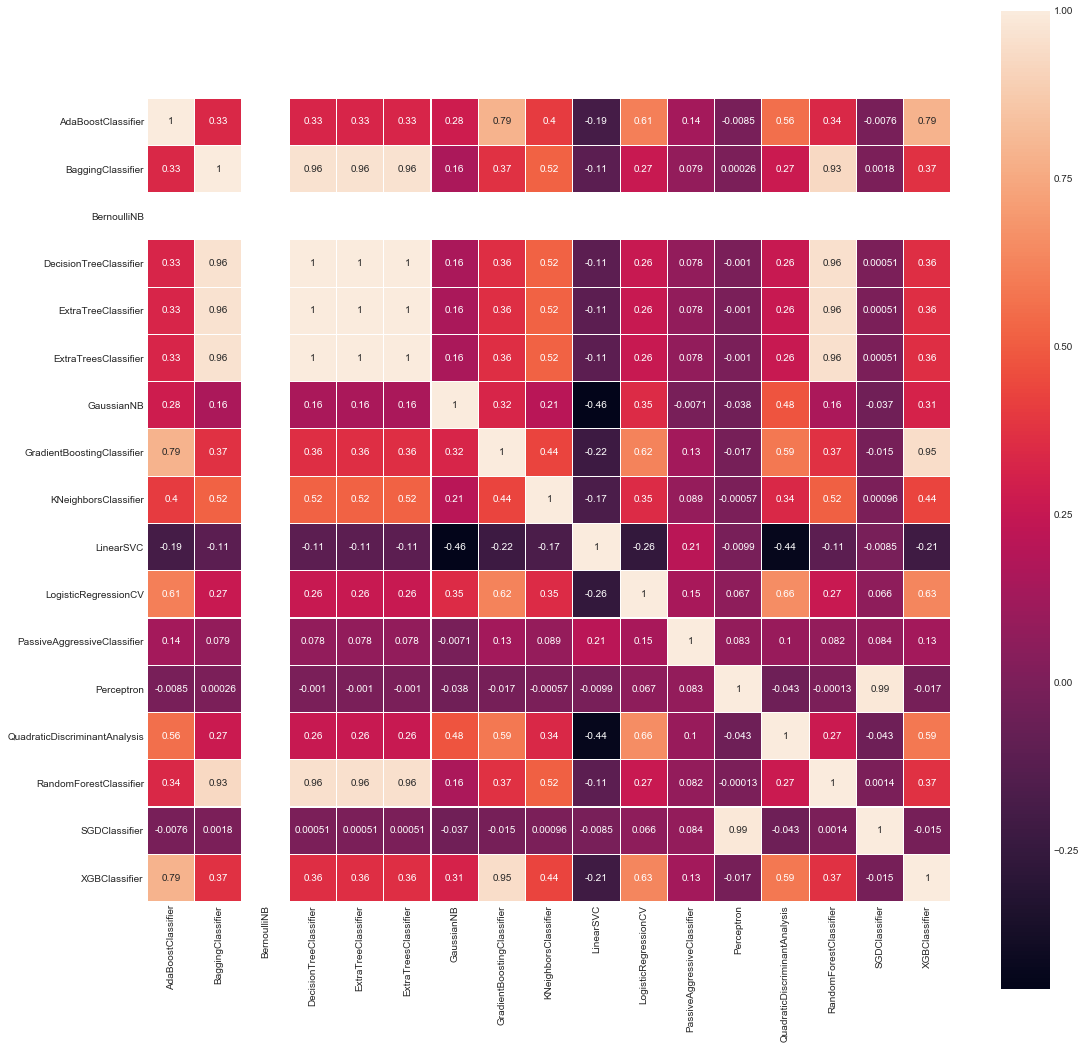

In [198]:
MLA_predict_pd = pd.DataFrame.from_dict(MLA_predict)
f, ax = plt.subplots(figsize = (18,18))
sns.heatmap(MLA_predict_pd.astype(float).corr(), 
            linewidths = 0.1, vmax = 1.0, ax = ax,
            square = True, linecolor = 'white', 
            annot = True)

In [ ]:
#  除此之外，还可以弄个rnn模型，从而，不单单考虑当前的transaction，而是考虑所有的，来得到最终结果

In [199]:
vote_est = [
    ('ada', ensemble.AdaBoostClassifier()),
    ('bc', ensemble.BaggingClassifier()),
    ('etc', ensemble.ExtraTreesClassifier()),
    ('gnb', naive_bayes.GaussianNB()),
    ('knn', neighbors.KNeighborsClassifier()),
    ('rf', ensemble.RandomForestClassifier()),
    ('bnb', naive_bayes.BernoulliNB()),
    ('sgd', linear_model.SGDClassifier()),
    ('pec', linear_model.Perceptron()),
    ('pac', linear_model.PassiveAggressiveClassifier()),
    ('lsvc', svm.LinearSVC())
]

In [200]:
vote_soft = ensemble.VotingClassifier(estimators = vote_est, voting = 'soft')
vote_soft_cv = model_selection.cross_validate(vote_soft, X_train, Y_train, cv =cv_split)
vote_soft.fit(X_train, Y_train)
print("Soft voting Training w/bin score mean: {:.2f}".format(vote_soft_cv['train_score'].mean()*100))
print("Soft voting Test w/bin score mean: {:.2f}".format(vote_soft_cv['test_score'].mean()*100))
print("Soft voting Test w/bin score 3*std: ±{:.2f}".format(vote_soft_cv['test_score'].std()*100*3))

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.

AttributeError: probability estimates are not available for loss='hinge'

In [201]:
vote_hard = ensemble.VotingClassifier(estimators = vote_est, voting = 'hard')
vote_hard_cv = model_selection.cross_validate(vote_hard, X_train, Y_train, cv = cv_split)
vote_hard.fit(X_train, Y_train)
print("Hard voting Training w/bin score mean: {:.2f}".format(vote_hard_cv['train_score'].mean()*100))
print("Hard voting Test w/bin score mean: {:.2f}".format(vote_hard_cv['test_score'].mean()*100))
print("Hard voting Test w/bin score 3*std: ±{:.2f}".format(vote_hard_cv['test_score'].std()*100*3))
print('-'*10)

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.

Hard voting Training w/bin score mean: 88.26
Hard voting Test w/bin score mean: 65.32
Hard voting Test w/bin score 3*std: ±5.48
----------


/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [289]:
test_model(ensemble.BaggingClassifier())

0.637375


In [290]:
finetune_model_ada = finetune_gridsearch('xgbc')
test_model(ensemble.BaggingClassifier())

0.63425


In [296]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68994 entries, 0 to 68993
Data columns (total 12 columns):
frequent_in_last_3_month                             68994 non-null float64
frequent_in_last_4_month                             68994 non-null float64
frequent_in_last_5_month                             68994 non-null float64
mean_km_distance_in_group                            68994 non-null float64
trend_of_frequent_in_the_past                        68994 non-null float64
km_distance_from_last_ordinal_encode_after_mdlp      68994 non-null float64
time_distance_from_last_ordinal_encode_after_mdlp    68994 non-null float64
num_act_ordinal_encode_after_mdlp                    68994 non-null float64
total AW_ordinal_encode_after_mdlp                   68994 non-null float64
KM-Stand_ordinal_encode_after_mdlp                   68994 non-null float64
Leistung (KW)_ordinal_encode_after_mdlp              68994 non-null float64
num_teile_ordinal_encode_after_mdlp                  68

In [205]:
# test the result with test set
def test_model(model):
    #model = ensemble.BaggingClassifier()
    model.fit(X_train, Y_train)
    Y_predict = model.predict(X_test)
    result = pd.concat([Y_test.reset_index().iloc[:,1:], pd.Series(Y_predict, name = 'predict')], axis = 1)
    print(len(result[result['weather_come_in_n_month'] == result['predict']])/len(result))

# CODE 

In [347]:
# MLP
# to use the classification model, you should change the codes in following position:
#   1. model = TS_mlp(12)
#   2. loss = torch.nn.CrossEntropyLoss()
#   3. train = CData(train_x, train_y)
#   4. test = CData(train_x, train_y)
#   5. test_loss, test_rate = test_model(dl_test, model, loss)
def run_mlp(train_x, train_y, test_x, test_y, b_s = 100, epochs = 100, verbose = True):
    """
    input:
      train_x, type of np array
        features of the training set
      train_y, type of np array
        target of the training set
      test_x, type of np array
        features of the testing set
      test_y, type of np array
        target of the testing set
    """
    # set models and loss
    model = TS_mlp2(12)
    #loss = torch.nn.CrossEntropyLoss()
    loss = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
    # set the scheduler
    lamb1 = lambda x: .1**(x//25)
    scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda = lamb1)
    # loda data
    train = RData(train_x, train_y)
    test = RData(test_x, test_y)
    dl_train = DataLoader(train, batch_size = b_s, shuffle = True)
    dl_test = DataLoader(test, batch_size = b_s, shuffle = True)
    # train the model
    num_epochs = epochs
    for epoch in range(num_epochs):
        scheduler.step()
        model.train()
        train_loss = 0
        counter = 0
        for batch_idx, dat in enumerate(dl_train):
            counter += 1
            # train the model
            optimizer.zero_grad()
            inp, target = dat
            out = model(inp)
            lo = loss(out, target)
            lo.backward()
            optimizer.step()
            train_loss += lo.data
            if verbose:
                if batch_idx % 10 == 0:
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch,
                        batch_idx * b_s,
                        len(train),
                        100.*batch_idx*b_s/len(train),
                        lo.data
                        ))
        test_lo, test_rate = test_model2(dl_test, model, loss)
        if verbose:
            # train loss
            print('====> Epoch: {} Average train loss: {:.4f}'.format(
                epoch,
                train_loss/counter
                ))
            # test loss
            print('====> Epoch: {} Average test loss: {:.4f} Average hit rate: {:.4f}'.format(
                epoch,
                test_lo,
                test_rate
                ))

#####################
# assist function
####################
class CData:
    def __init__(self, x, y):
        """
        input:
            x: np array
              training features
            y: np array
              training target
        """
        self.data = {}
        self.data['train_x'] = torch.from_numpy(x).type(torch.FloatTensor)
        self.data['train_y'] = torch.from_numpy(y).type(torch.LongTensor)
        assert(len(self.data['train_x']) == len(self.data['train_y']))
        self.len = len(self.data['train_x'])

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return (self.data['train_x'][index],
                self.data['train_y'][index])
    
class RData:
    def __init__(self, x, y):
        """
        input:
            x: np array
              training features
            y: np array
              training target
        """
        self.data = {}
        self.data['train_x'] = torch.from_numpy(x).type(torch.FloatTensor)
        self.data['train_y'] = torch.from_numpy(y).type(torch.FloatTensor)
        assert(len(self.data['train_x']) == len(self.data['train_y']))
        self.len = len(self.data['train_x'])

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return (self.data['train_x'][index],
                self.data['train_y'][index])

def test_model(dl_test, model, loss):
    """
    for classificator
    """
    model.eval()
    test_loss = 0
    test_rate = 0
    counter = 0
    for batch_idx, dat in enumerate(dl_test):
        counter += 1
        #TODO codes to be changed
        inp, target = dat
        out = model(inp)
        lo = loss(out, target)
        rate = (out.max(dim = 1)[1] == target).sum()
        test_loss += lo.data
        test_rate += rate
    test_rate = 1.0*test_rate/len(dl_test)
    return test_loss/counter, test_rate

def test_model2(dl_test, model, loss):
    """
    for regression
    """
    model.eval()
    test_loss = 0
    test_rate = 0
    counter = 0
    for batch_idx, dat in enumerate(dl_test):
        counter += 1
        #TODO codes to be changed
        inp, target = dat
        out = model(inp)
        lo = loss(out, target)
        rate = (out.round() == target).sum()
        test_loss += lo.data
        test_rate += rate
    test_rate = 1.0*test_rate/len(dl_test)
    return test_loss/counter, test_rate
########################
## model
########################
class TS_mlp(torch.nn.Module):
    def __init__(self, dim_input = 7):
        super(TS_mlp, self).__init__()
        num_hidden = 128
        self.mlp = torch.nn.Sequential(
                torch.nn.Linear(dim_input, num_hidden),
                #torch.nn.Dropout(),
                torch.nn.BatchNorm1d(128),
                torch.nn.ReLU(),
                torch.nn.Linear(num_hidden, 2),
                )
    
    def forward(self, inp):
        out = self.mlp(inp)
        return out.squeeze()
class TS_mlp2(torch.nn.Module):
    def __init__(self, dim_input = 7):
        super(TS_mlp2, self).__init__()
        num_hidden = 128
        self.mlp = torch.nn.Sequential(
                torch.nn.Linear(dim_input, num_hidden),
                #torch.nn.Dropout(),
                torch.nn.BatchNorm1d(128),
                torch.nn.ReLU(),
                torch.nn.Linear(num_hidden, 1),
                )
    
    def forward(self, inp):
        out = self.mlp(inp)
        return out.squeeze()

In [209]:
# finetune
def _get_param_grid_and_model_for_gridsearch(model = 'ada'):
    """
    input:
        model: type of model
    output:
        param_grid, type of dict
        mod: MLA model 
    """
    grid_n_estimator = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
    grid_ratio = [.1, .25, .5, .75, 1.0]
    grid_learn = [.01, .03, .05, .1, .25]
    grid_max_depth = [2, 4, 6, 8, 10, None]
    grid_min_samples = [5, 10, .03, .05, .01]
    grid_criterion = ['gini', 'entropy']
    grid_bool = [True, False]
    grid_seed = [0]
    if model == 'adaBoost':
        grid_param = {
#                'base_estimator__criterion': ['gini', 'entropy'],
#                'base_estimator__splitter': ['best', 'random'],
                'n_estimators': grid_n_estimator, # default = 50
                'learning_rate': grid_learn, # default = 1
                'algorithm': ['SAMME', 'SAMME.R'], # default = 'SAMME.R'
                'random_state': grid_seed
                }
        mod = ensemble.AdaBoostClassifier()
    elif model == 'bagging':
        grid_param = {
                'n_estimators': grid_n_estimator, # default = 10
                'max_samples': grid_ratio, # default = 1.0
                'random_state': grid_seed
                }
        mod = ensemble.BaggingClassifier()
    elif model == 'extraTrees':
        grid_param = {
                'n_estimators': grid_n_estimator, # default  = 10
                'criterion': grid_criterion, # default = 'gini'
                'max_depth': grid_max_depth, # default = None
                'max_features': [1, 3, 7],
                'min_samples_split': [2, 3, 7],
                'min_samples_leaf': [1, 3, 7],
                'bootstrap': [False],
                'random_state': grid_seed
                }
        mod = ensemble.ExtraTreesClassifier()
    elif model == 'gradientBoosting':
        grid_param = {
                'loss': ['deviance', 'exponential'], # default = 'deviance'
                'learning_rate': [.1, .05, .01], # default = 0.1
                'n_estimators': [300], # default = 100
                'criterion': ['friedman_mse', 'mse', 'mae'], # default = 'friedman_mse'
                'max_depth': grid_max_depth, # default = 3
                'min_samples_leaf': [100,150],
                'max_features': [.3, .1],
                'random_state': grid_seed
                }
        mod = ensemble.GradientBoostingClassifier()
    elif model == 'randomForest':
        grid_param = {
                'n_estimators': grid_n_estimator, # default = 0
                'criterion': grid_criterion, # default = 'gini'
                'max_depth': grid_max_depth, # default = None
                'oob_score': [True], # default = False
                'random_state': grid_seed,
                'min_samples_split': [2, 3, 7],
                'min_samples_leaf': [1, 3, 7],
                }
        mod = ensemble.RandomForestClassifier()
    elif model == 'gaussianProcess':
        grid_param = {
                'max_iter_predict': grid_n_estimator, # default = 100
                'random_state': grid_seed
                }
        mod = gaussian_process.GaussianProcessClassifier()
    elif model == 'decisionTree':
        param_grid = {
                'criterion': ['gini', 'entropy'], # default gini
                'splitter': ['best', 'random'], # default best
                'max_depth': [2, 4, 6, 8, 10, None], # default None
                'min_samples_split': [2, 5, 10, .03, .05], # minimum subset size before new split, default 2
                'min_samples_lear': [1, 5, 10, .03, .05], # minimum subset size after new split, default 1
                'max_features': [None, 'auto'], # max features to consider when performing split; default noen or all
                'random_state': [0] # seed or control random number generator
                }
        mod = tree.DecisionTreeClassifier()
    elif model == 'logisticRegression':
        grid_param = {
                'fit_intercept': grid_bool, # default = True
                #'penalty': ['11', '12'],
                'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], # default: lbfgs
                'random_state': grid_seed
                }
        mod = linear_model.LogisticRegressionCV() # ??
    elif model == 'bernoulliNB':
        grid_param = {
                'alpha': grid_ratio, # default1.0
                }
        mod = naive_bayes.BernoulliNB()
    elif model == 'kNeighbors':
        grid_param = {
                'n_neighbors': [1, 2, 3, 4, 5, 6, 7], # default = 5
                'weights': ['uniform', 'distance'], #default = 'uniform'
                'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
                }
        mod = neighbors.KNeighborsClassifier()
    elif model == 'svc':
        grid_param = {
                'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                'C': [1, 5, 10, 50, 100, 200, 300, 1000], # default = 1.0
                'gamma': grid_ratio, # default = auto
                'decision_function_shape': ['ovo', 'ovr'], # default = ovr
                'probability': [True],
                'random_state': grid_seed
                }
        mod = svm.SVC(probability = True)
    elif model == 'xgbc':
        grid_param = {
                'learning_rate': grid_learn, # default = .3
                'max_depth': [1, 2, 4, 6, 8, 10], # default = 2
                'n_estimators': grid_n_estimator,
                'seed': grid_seed
                }
        mod = XGBClassifier()
    else:
        print('unrecognized model: '+ model)
    return grid_param, mod
def finetune_gridsearch(model = 'adaBoost'):
    """
    ada: AdaBoostClassifier
    """
    param_grid, mod = _get_param_grid_and_model_for_gridsearch(model)
    cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0)
    tune_model = model_selection.GridSearchCV(mod, param_grid = param_grid, scoring = 'roc_auc', cv = cv_split)
    return tune_model

In [2]:
def check_to_1(df, atta, attb):
    """
    input:
        df, Dataframe:
            the data frame
        atta, string:
            first attribute
        attb, string:
            second attribute
    output:
        out boolean:
            if for an a has more than one b, return True, otherwise return False
    """
    df = df[[atta, attb]]
    df.to_csv('/tmp/tmp.csv', sep = ';', index = False)
    abdict = ABDict('/tmp/tmp.csv', header = True, sep = ';')
    dic = abdict.dic
    flag = 0
    for i,j in dic.items():
        if len(j) > 1:
            print(str(i) + '\t' + str(j))

In [3]:
# 转化为auftrag table， 但是这次合并的是Teile-Nr项
# 给的数据的每一行都是一个维修项，初衷是，把属于同一个auftrag的维修项合并到一起，看一下，在同一个Auftrag中，经常一起修的是那些内容

def toAuftragTable(df, att, auftn, clean = True):
    """
    input:
        df, DataFrame:
            the dataframe
        att, string:
            the column name of the target attribute
        auftn, string:
            the column name of the aftragsnummer attribute
        clean:
            when true, drop the null item in auftn attribute.
    output:
        df_g, DataFrame:
            dataframe contrains two columns auftn and att
            type of item in att is string, separate with ';'
    """
    # assert: make sure the type of the attributes inputted
    
    # extract the att and date columns
    df = df[[att, auftn]]
    # set type to object
    #df[att] = df[att].astype('object')
    #df[auftn] = df[auftn].astype('object')
    # if clean is True, drop the fake data, like the null data
    if clean:
        print("Falls Null date exist, drop these dates directly")
        #df = df.drop(df[df[att].isnull()].index)
        df = df.drop(df[df[auftn].isnull()].index)
    # group and sum 
    df_g = df.groupby([auftn], as_index = False).apply(agg)
    return df_g

# apply 只能对单行进行处理，而不是对整个分组进行处理，所以估计应该把axis换成1，比较好
def agg(x):
    # 是否用‘ ’分隔会比较好，这样就不用对初始的属性，
    # x 在这里是dataframe？？？
    #x = [str(i) for i in x]
    x = x.apply(lambda x: ';'.join(set([str(i) for i in x])), axis = 0)
    #x = x.apply(lambda x: ' '.join(set(x)), axis = 0)
    #print(x.columns.values)
    return x

In [4]:
class ABDict:
    """
    make sure that only two columns in the df, otherwise only the first two columns will be used
    用于两列数据互补空值
    """
    def __init__(self, path, header = True, sep = ';'):
        self.dic = self._load_dict(path, header, sep) 
        self.dic_conv = self._load_dict_conv(path, header, sep)
        print(len(self.dic))
        print(len(self.dic_conv))
        counter = 0
        ########
        # test #
        ########
        #for i in self.dic.keys():
        #    if counter > 1:
        #        break
        #    print(i, self.dic[i])
        #    counter += 1
        #print('schraube' in self.dic_conv.keys())
    
    def AToB(self, a):
        if a in self.dic.keys():
            out = self.dic[a][0]
            if type(out) == list:
                print(out)
            return out
        else:
            #print(a)
            return float('nan')
    
    def BToA(self, b):
        if b in self.dic_conv.keys():
            out = self.dic_conv[b][0]
            #print(out)
            return out
        else:
            #print(b)
            return float('nan')

    def _load_dict(self, path, header, sep):
        dic = {} 
        with open(path) as fi:
            counter = 0
            for li in fi:
                if header and counter ==0:
                    # drop first line if header is true
                    counter += 1
                    continue
                li = li.strip()   # 忘记去换行符了，导致调了一晚上的错
                items = li.split(sep)
                if items[0] not in dic.keys():
                    # if not exit, add new item
                    if items[1] != 'nan':
                        dic[items[0]] = [items[1]]
                elif items[1] not in dic[items[0]]:
                    # if item exit but value not eixt, add the value to the list
                    dic[items[0]].append(items[1])
                counter += 1
        return dic
    
    def _load_dict_conv(self, path, header, sep):
        dic = {}
        with open(path) as fi:
            counter = 0
            for li in fi:
                if header and counter == 0:
                    # drop first line if header is true
                    counter += 1
                    continue
                li = li.strip()
                items = li.split(sep)
                if items[1] not in dic.keys():
                    if items[0] != 'nan':
                        #print(items[0])
                        dic[items[1]] = [items[0]]
                elif items[0] not in dic[items[1]]:
                    dic[items[1]].append(items[0])
                counter += 1
        return dic

In [5]:
import pandas as pd
import numpy as np
from math import log
import random


def entropy(data_classes, base=2):
    '''
    Computes the entropy of a set of labels (class instantiations)
    :param base: logarithm base for computation
    :param data_classes: Series with labels of examples in a dataset
    :return: value of entropy
    '''
    if not isinstance(data_classes, pd.core.series.Series):
        raise AttributeError('input array should be a pandas series')
    classes = data_classes.unique()
    N = len(data_classes)
    ent = 0  # initialize entropy

    # iterate over classes
    for c in classes:
        partition = data_classes[data_classes == c]  # data with class = c
        proportion = len(partition) / N
        #update entropy
        ent -= proportion * log(proportion, base)

    return ent

def cut_point_information_gain(dataset, cut_point, feature_label, class_label):
    '''
    Return de information gain obtained by splitting a numeric attribute in two according to cut_point
    :param dataset: pandas dataframe with a column for attribute values and a column for class
    :param cut_point: threshold at which to partition the numeric attribute
    :param feature_label: column label of the numeric attribute values in data
    :param class_label: column label of the array of instance classes
    :return: information gain of partition obtained by threshold cut_point
    '''
    if not isinstance(dataset, pd.core.frame.DataFrame):
        raise AttributeError('input dataset should be a pandas data frame')

    entropy_full = entropy(dataset[class_label])  # compute entropy of full dataset (w/o split)

    #split data at cut_point
    data_left = dataset[dataset[feature_label] <= cut_point]
    data_right = dataset[dataset[feature_label] > cut_point]
    (N, N_left, N_right) = (len(dataset), len(data_left), len(data_right))

    gain = entropy_full - (N_left / N) * entropy(data_left[class_label]) - \
        (N_right / N) * entropy(data_right[class_label])

    return gain

In [6]:
from __future__ import division
__author__ = 'Victor Ruiz, vmr11@pitt.edu'
import pandas as pd
import numpy as np
from math import log
import sys
import getopt
import re

class MDLP_Discretizer(object):
    def __init__(self, dataset, class_label, out_path_data=None, out_path_bins=None, features=None):
        '''
        initializes discretizer object:
            saves raw copy of data and creates self._data with only features to discretize and class
            computes initial entropy (before any splitting)
            self._features = features to be discretized
            self._classes = unique classes in raw_data
            self._class_name = label of class in pandas dataframe
            self._data = partition of data with only features of interest and class
            self._cuts = dictionary with cut points for each feature
        :param dataset: pandas dataframe with data to discretize
        :param class_label: name of the column containing class in input dataframe
        :param features: if !None, features that the user wants to discretize specifically
        :return:
        '''

        if not isinstance(dataset, pd.core.frame.DataFrame):  # class needs a pandas dataframe
            raise AttributeError('input dataset should be a pandas data frame')

        self._data_raw = dataset #copy or original input data

        self._class_name = class_label

        self._classes = self._data_raw[self._class_name] #.unique()
        self._classes.drop_duplicates()


        #if user specifies which attributes to discretize
        if features:
            self._features = [f for f in features if f in self._data_raw.columns]  # check if features in dataframe
            missing = set(features) - set(self._features)  # specified columns not in dataframe
            if missing:
                print('WARNING: user-specified features %s not in input dataframe' % str(missing))
        else:  # then we need to recognize which features are numeric
            numeric_cols = self._data_raw._data.get_numeric_data().items
            self._features = [f for f in numeric_cols if f != class_label]
        #other features that won't be discretized
        self._ignored_features = set(self._data_raw.columns) - set(self._features)

        #create copy of data only including features to discretize and class
        self._data = self._data_raw.loc[:, self._features + [class_label]]
        self._data = self._data.convert_objects(convert_numeric=True)
        #pre-compute all boundary points in dataset
        self._boundaries = self.compute_boundary_points_all_features()
        #initialize feature bins with empty arrays
        self._cuts = {f: [] for f in self._features}
        #get cuts for all features
        self.all_features_accepted_cutpoints()
        #discretize self._data
        #self.apply_cutpoints(out_data_path=out_path_data, out_bins_path=out_path_bins)

    def MDLPC_criterion(self, data, feature, cut_point):
        '''
        Determines whether a partition is accepted according to the MDLPC criterion
        :param feature: feature of interest
        :param cut_point: proposed cut_point
        :param partition_index: index of the sample (dataframe partition) in the interval of interest
        :return: True/False, whether to accept the partition
        '''
        #get dataframe only with desired attribute and class columns, and split by cut_point
        data_partition = data.copy(deep=True)
        data_left = data_partition[data_partition[feature] <= cut_point]
        data_right = data_partition[data_partition[feature] > cut_point]

        #compute information gain obtained when splitting data at cut_point
        cut_point_gain = cut_point_information_gain(dataset=data_partition, cut_point=cut_point,
                                                    feature_label=feature, class_label=self._class_name)
        #compute delta term in MDLPC criterion
        N = len(data_partition) # number of examples in current partition
        partition_entropy = entropy(data_partition[self._class_name])
        k = len(data_partition[self._class_name].unique())
        k_left = len(data_left[self._class_name].unique())
        k_right = len(data_right[self._class_name].unique())
        entropy_left = entropy(data_left[self._class_name])  # entropy of partition
        entropy_right = entropy(data_right[self._class_name])
        delta = log(3 ** k, 2) - (k * partition_entropy) + (k_left * entropy_left) + (k_right * entropy_right)

        #to split or not to split
        gain_threshold = (log(N - 1, 2) + delta) / N

        if cut_point_gain > gain_threshold:
            return True
        else:
            return False

    def feature_boundary_points(self, data, feature):
        '''
        Given an attribute, find all potential cut_points (boundary points)
        :param feature: feature of interest
        :param partition_index: indices of rows for which feature value falls whithin interval of interest
        :return: array with potential cut_points
        '''
        #get dataframe with only rows of interest, and feature and class columns
        data_partition = data.copy(deep=True)
        data_partition.sort_values(feature, ascending=True, inplace=True)

        boundary_points = []

        #add temporary columns
        data_partition['class_offset'] = data_partition[self._class_name].shift(1)  # column where first value is now second, and so forth
        data_partition['feature_offset'] = data_partition[feature].shift(1)  # column where first value is now second, and so forth
        data_partition['feature_change'] = (data_partition[feature] != data_partition['feature_offset'])
        data_partition['mid_points'] = data_partition.loc[:, [feature, 'feature_offset']].mean(axis=1)

        potential_cuts = data_partition[data_partition['feature_change'] == True].index[1:]
        sorted_index = data_partition.index.tolist()

        for row in potential_cuts:
            old_value = data_partition.loc[sorted_index[sorted_index.index(row) - 1]][feature]
            new_value = data_partition.loc[row][feature]
            old_classes = data_partition[data_partition[feature] == old_value][self._class_name].unique()
            new_classes = data_partition[data_partition[feature] == new_value][self._class_name].unique()
            if len(set.union(set(old_classes), set(new_classes))) > 1:
                boundary_points += [data_partition.loc[row]['mid_points']]

        return set(boundary_points)

    def compute_boundary_points_all_features(self):
        '''
        Computes all possible boundary points for each attribute in self._features (features to discretize)
        :return:
        '''
        boundaries = {}
        for attr in self._features:
            data_partition = self._data.loc[:, [attr, self._class_name]]
            boundaries[attr] = self.feature_boundary_points(data=data_partition, feature=attr)
        return boundaries

    def boundaries_in_partition(self, data, feature):
        '''
        From the collection of all cut points for all features, find cut points that fall within a feature-partition's
        attribute-values' range
        :param data: data partition (pandas dataframe)
        :param feature: attribute of interest
        :return: points within feature's range
        '''
        range_min, range_max = (data[feature].min(), data[feature].max())
        return set([x for x in self._boundaries[feature] if (x > range_min) and (x < range_max)])

    def best_cut_point(self, data, feature):
        '''
        Selects the best cut point for a feature in a data partition based on information gain
        :param data: data partition (pandas dataframe)
        :param feature: target attribute
        :return: value of cut point with highest information gain (if many, picks first). None if no candidates
        '''
        candidates = self.boundaries_in_partition(data=data, feature=feature)
        # candidates = self.feature_boundary_points(data=data, feature=feature)
        if not candidates:
            return None
        gains = [(cut, cut_point_information_gain(dataset=data, cut_point=cut, feature_label=feature,
                                                  class_label=self._class_name)) for cut in candidates]
        gains = sorted(gains, key=lambda x: x[1], reverse=True)

        return gains[0][0] #return cut point

    def single_feature_accepted_cutpoints(self, feature, partition_index=pd.DataFrame().index):
        '''
        Computes the cuts for binning a feature according to the MDLP criterion
        :param feature: attribute of interest
        :param partition_index: index of examples in data partition for which cuts are required
        :return: list of cuts for binning feature in partition covered by partition_index
        '''
        if partition_index.size == 0:
            partition_index = self._data.index  # if not specified, full sample to be considered for partition

        data_partition = self._data.loc[partition_index, [feature, self._class_name]]

        #exclude missing data:
        if data_partition[feature].isnull().values.any:
            data_partition = data_partition[~data_partition[feature].isnull()]

        #stop if constant or null feature values
        if len(data_partition[feature].unique()) < 2:
            return
        #determine whether to cut and where
        cut_candidate = self.best_cut_point(data=data_partition, feature=feature)
        if cut_candidate == None:
            return
        decision = self.MDLPC_criterion(data=data_partition, feature=feature, cut_point=cut_candidate)

        #apply decision
        if not decision:
            return  # if partition wasn't accepted, there's nothing else to do
        if decision:
            # try:
            #now we have two new partitions that need to be examined
            left_partition = data_partition[data_partition[feature] <= cut_candidate]
            right_partition = data_partition[data_partition[feature] > cut_candidate]
            if left_partition.empty or right_partition.empty:
                return #extreme point selected, don't partition
            self._cuts[feature] += [cut_candidate]  # accept partition
            self.single_feature_accepted_cutpoints(feature=feature, partition_index=left_partition.index)
            self.single_feature_accepted_cutpoints(feature=feature, partition_index=right_partition.index)
            #order cutpoints in ascending order
            self._cuts[feature] = sorted(self._cuts[feature])
            return

    def all_features_accepted_cutpoints(self):
        '''
        Computes cut points for all numeric features (the ones in self._features)
        :return:
        '''
        for attr in self._features:
            self.single_feature_accepted_cutpoints(feature=attr)
        return

    def apply_cutpoints(self, out_data_path=None, out_bins_path=None):
        '''
        Discretizes data by applying bins according to self._cuts. Saves a new, discretized file, and a description of
        the bins
        :param out_data_path: path to save discretized data
        :param out_bins_path: path to save bins description
        :return:
        '''
        bin_label_collection = {}
        for attr in self._features:
            if len(self._cuts[attr]) == 0:
                self._data[attr] = 'All'
                bin_label_collection[attr] = ['All']
            else:
                cuts = [-np.inf] + self._cuts[attr] + [np.inf]
                start_bin_indices = range(0, len(cuts) - 1)
                bin_labels = ['%s_to_%s' % (str(cuts[i]), str(cuts[i+1])) for i in start_bin_indices]
                bin_label_collection[attr] = bin_labels
                self._data[attr] = pd.cut(x=self._data[attr].values, bins=cuts, right=False, labels=bin_labels,
                                          precision=6, include_lowest=True)

        #reconstitute full data, now discretized
        if self._ignored_features:
            to_return = pd.concat([self._data, self._data_raw[list(self._ignored_features)]], axis=1)
            to_return = to_return[self._data_raw.columns] #sort columns so they have the original order
        else:
            to_return = self._data
        
        return to_return
    
        #save data as csv
        if out_data_path:
            to_return.to_csv(out_data_path)
        #save bins description
        if out_bins_path:
            with open(out_bins_path, 'w') as bins_file:
                print>>bins_file, 'Description of bins in file: %s' % out_data_path
                for attr in self._features:
                    print>>bins_file, 'attr: %s\n\t%s' % (attr, ', '.join([bin_label for bin_label in bin_label_collection[attr]]))

